In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn  import preprocessing, decomposition, base
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, SGDClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, make_scorer, roc_curve, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.formula.api as sm
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_importance
import time

from IPython.display import display
pd.options.display.max_columns = 40
from datetime import datetime

#from utils import KFoldTargetEncoderTrain, KFoldTargetEncoderTest 
#from utils import *

os.getcwd()

'C:\\Users\\feder\\Desktop\\Enel\\Models&Datasets_final'

In [2]:
def title_ticks_ecc(title, xlabel, ylabel, new_fig= True , figsize= (10,6)):
    if new_fig== True:
        plt.figure(figsize=figsize)
        
    plt.title(title, color='red', fontsize= 18, pad= 13)
    plt.xlabel(xlabel, color='red', fontsize= 14)
    plt.ylabel(ylabel, color='red', fontsize= 14)
    plt.xticks(fontsize=12, color='blue')
    plt.yticks(fontsize=12, color='blue')
    
def F_beta(beta, x, y):
    """metti beta davanti a quello a cui vuoi dare meno peso, di default y"""
    return (1+ beta)* x*y/ (x + y*beta)

In [3]:
df_rolling_clean_class= pd.read_pickle('../../dati_enel_v3/10_snapshots/df_rolling_clean_class_10snap.pk1')
df_rolling_clean_reg= pd.read_pickle('../../dati_enel_v3/10_snapshots/df_rolling_clean_reg_10snap.pk1')

df_rolling_clean_class.shape, df_rolling_clean_reg.shape  #(304564, 42), (89596, 42), REGRESSIONE SOLO SU LABEL= 2

((304564, 42), (89596, 42))

In [4]:
df_rolling_clean_class.head()

,Purchase document,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,QMG Code,VMD Code,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Main Requesting unit,Professional services flag,num_orders,avg_importo_ordine,...,std_order_intervals,life%,days_since_beginning,days_til_first_order,days_til_last_order,durata_nominale_gg,percentage_used,ordini/mese,label,final_used,True/Ideal Slope,life%_enc,gg rimanenti Statico,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used
10,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,0,-100.000,...,-100.0,0%,0,-100,-100,1303,0.00,0.00,2,97.81,NaN,0,1166,0.000,0.000,0.000,0.000,4,0.000,0.000
11,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,1543,487.861,...,1.0,10%,130,39,130,1303,7.68,356.08,2,97.81,0.8,1,1166,0.000,0.000,0.000,0.000,4,1.000,1.000
12,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,3266,443.988,...,0.7,20%,260,39,260,1303,14.80,376.85,2,97.81,0.7,2,1166,0.419,0.376,0.205,0.000,4,1.117,0.927
13,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,5096,427.457,...,0.6,30%,390,39,390,1303,22.23,392.00,2,97.81,0.7,3,1166,0.268,0.241,0.251,0.239,4,1.062,1.044
14,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,6736,442.263,...,0.6,40%,521,39,521,1303,30.40,387.87,2,97.81,0.8,4,1166,0.417,0.274,0.209,0.099,4,0.896,1.100


In [10]:
durate_nomin= pd.DataFrame(pd.Series(
    dict(zip(df_rolling_clean_class['Purchase document'], df_rolling_clean_class['durata_nominale_gg']))))

durate_nomin.to_pickle('durate_nominali.pk1')

In [13]:
contr_piu_feats_create= ['Purchase document']+ list(df_rolling_clean_reg.iloc[:5, 18:].columns)
feats_create= contr_piu_feats_create

feats_binarie= ['Variant code',
 'Contract Type',
 'Main material group qualification flag',
 'Professional services flag']

In [17]:
df= df_rolling_clean_reg.copy()
df[df['num_orders'].isin([0])][contr_piu_feats_create].head(3)

,Purchase document,num_orders,avg_importo_ordine,std_importo_ordine,avg_order_intervals,std_order_intervals,life%,days_since_beginning,days_til_first_order,days_til_last_order,durata_nominale_gg,percentage_used,ordini/mese,label,final_used,True/Ideal Slope,life%_enc,gg rimanenti Statico,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used
10,DI\8400060305,0,-100.0,-100.0,-100.0,-100.0,0%,0,-100,-100,1303,0.0,0.0,2,97.81,NaN,0,1166,0.0,0.0,0.0,0.0,4,0.0,0.0
80,EL\5800012947,0,-100.0,-100.0,-100.0,-100.0,0%,0,-100,-100,1095,0.0,0.0,2,97.12,NaN,0,771,0.0,0.0,0.0,0.0,3,0.0,0.0
100,PR\8400056460,0,-100.0,-100.0,-100.0,-100.0,0%,0,-100,-100,682,0.0,0.0,2,96.95,NaN,0,622,0.0,0.0,0.0,0.0,4,0.0,0.0


#### Analysis on avg interval, in % in respect to nominal duration

In [21]:
perc_avg_intervals= df_rolling_clean_class.apply(
    lambda row: round(row['avg_order_intervals']*100/row['durata_nominale_gg'],2) if row['avg_order_intervals']>0 else -1, axis=1)


perc_std_intervals= df_rolling_clean_class.apply(
    lambda row: round(row['std_order_intervals']*100/row['avg_order_intervals'],2) if row['avg_order_intervals']>0 else -1, axis=1)

## Statistica solo di chi fa ordini, % intervallo di tempo rispetto a durata nominale
perc_avg_intervals[perc_avg_intervals>0].describe()   #in media, li faccio ogni 9% di vita

count    164619.000000
mean          9.638689
std          11.460599
min           0.010000
25%           2.710000
50%           6.090000
75%          11.560000
max          90.000000
dtype: float64

### Some Descriptive Visualizations

In [22]:
perc_avg_intervals= df_rolling_clean_class['avg_order_intervals']/ df_rolling_clean_class['durata_nominale_gg']
perc_avg_intervals= perc_avg_intervals[perc_avg_intervals>0]

perc_avg_intervals_reg= df_rolling_clean_reg['avg_order_intervals']/ df_rolling_clean_reg['durata_nominale_gg']
perc_avg_intervals_reg= perc_avg_intervals_reg[perc_avg_intervals_reg>0]

In [23]:
perc_std_intervals= df_rolling_clean_class['std_order_intervals']/ df_rolling_clean_class['avg_order_intervals']
perc_std_intervals= perc_std_intervals[perc_std_intervals>0]

perc_std_intervals_reg= df_rolling_clean_reg['std_order_intervals']/ df_rolling_clean_reg['avg_order_intervals']
perc_std_intervals_reg= perc_std_intervals_reg[perc_std_intervals_reg>0]

([<matplotlib.axis.YTick at 0x1f506e064a8>,
 <a list of 11 Text yticklabel objects>)

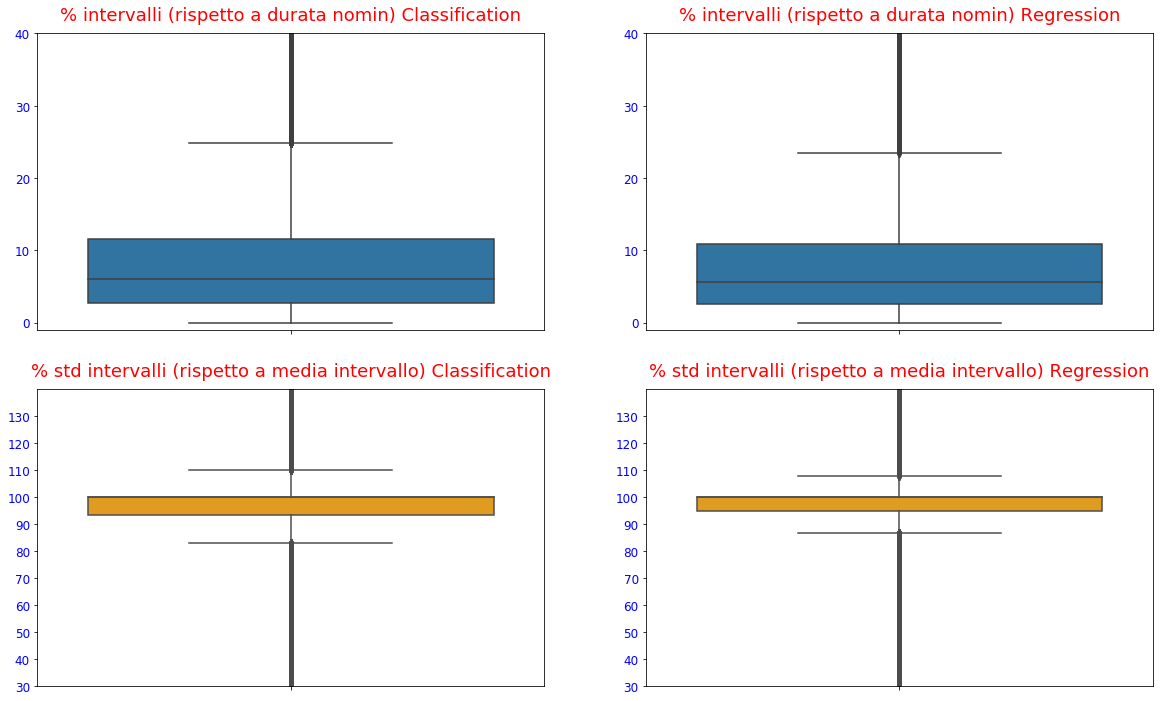

In [24]:
plt.figure(figsize=(20, 12))

y= [str(col)+'%' for col in np.arange(0, 100, 10)]

plt.subplot(2, 2, 1)
title_ticks_ecc('% intervalli (rispetto a durata nomin) Classification','','', new_fig=False)
sns.boxplot(perc_avg_intervals*100, orient='v')
plt.ylim(-1, 40)
plt.yticks(np.arange(0, 50, 10))

plt.subplot(2, 2, 2)
title_ticks_ecc('% intervalli (rispetto a durata nomin) Regression','','', new_fig=False)
sns.boxplot(perc_avg_intervals_reg*100, orient='v')
plt.ylim(-1, 40)
plt.yticks(np.arange(0, 50, 10))

plt.subplot(2, 2, 3)
title_ticks_ecc('% std intervalli (rispetto a media intervallo) Classification','','', new_fig=False)
sns.boxplot(perc_std_intervals*100, orient='v', color= 'orange')
plt.ylim(30, 140)
plt.yticks(np.arange(30, 140, 10))

plt.subplot(2, 2, 4)
title_ticks_ecc('% std intervalli (rispetto a media intervallo) Regression','','', new_fig=False)
sns.boxplot(perc_std_intervals_reg*100, orient='v', color='orange')
plt.ylim(30, 140)
plt.yticks(np.arange(30, 140, 10))

([<matplotlib.axis.YTick at 0x1f510a312e8>,
 <a list of 4 Text yticklabel objects>)

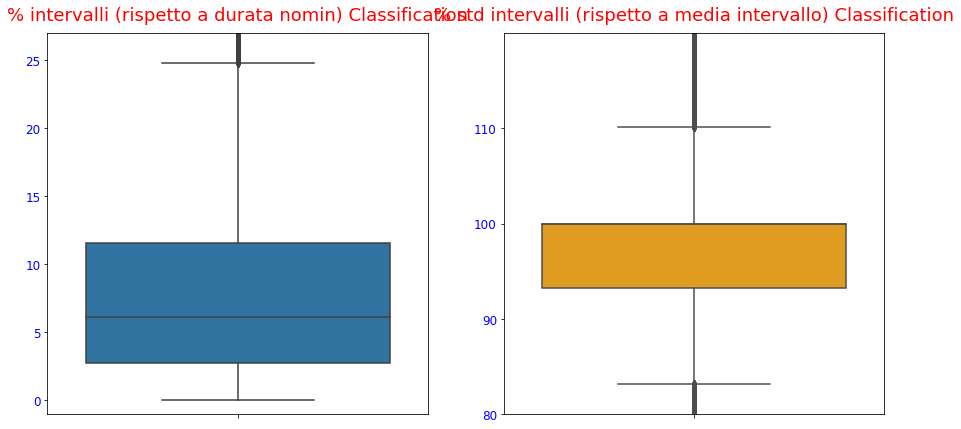

In [37]:
plt.figure(figsize=(15, 7))

y= [str(col)+'%' for col in np.arange(0, 100, 10)]

plt.subplot(1, 2, 1)
title_ticks_ecc('% intervalli (rispetto a durata nomin) Classification','','', new_fig=False)
sns.boxplot(perc_avg_intervals*100, orient='v')
plt.ylim(-1, 27)
plt.yticks(np.arange(0, 27, 5))

plt.subplot(1, 2, 2)
title_ticks_ecc('% std intervalli (rispetto a media intervallo) Classification','','', new_fig=False)
sns.boxplot(perc_std_intervals*100, orient='v', color= 'orange')
plt.ylim(80, 120)
plt.yticks(np.arange(80, 115, 10))

In [20]:
## convert life% from ordinal to float

df_rolling_clean_class['life%'] = df_rolling_clean_class['life%'].apply(lambda x: int(x[:-1])/100)
df_rolling_clean_class['life%'].unique()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [238]:
cardinalita={}
for col in df_rolling_clean_class.select_dtypes(include=[object]).columns:
    cardinalita[col]= df_rolling_clean_class[col].nunique()
cardinalita= pd.Series(cardinalita)
cardinalita= cardinalita.sort_values(ascending=False)
#d= d.drop('life%')
cardinalita= pd.DataFrame(cardinalita, columns= ['cardinalità_classe'])
cardinalita.head(10)

,cardinalità_classe
Purchase document,37797
VMD Code,12191
QMG Code,878
Main Requesting unit,543
Purchase Unit Code,76
Country Code,60
Purchase Country Code,13
Global Purchase Unit Code,13
life%,10
Global Business line,8


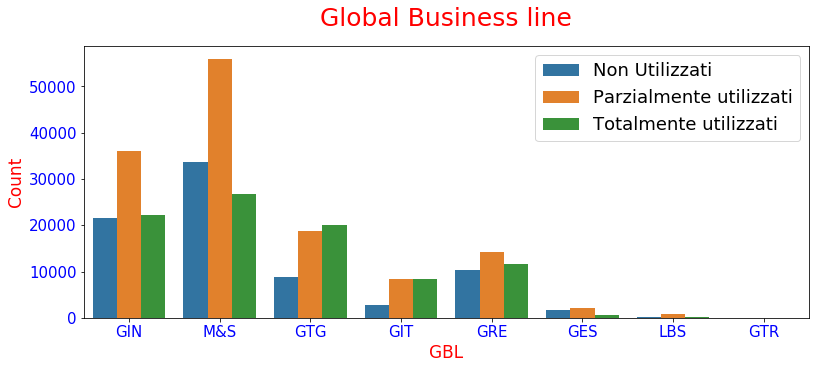

In [27]:
gbl= df_rolling_clean_class['Global Business line']  #.value_counts()
#sns.distplot(gbl, hist= True, kde= False)

plt.figure(figsize=(13,5))
plt.title('Global Business line', fontsize=25, color= 'r', pad=20)
sns.countplot(gbl, hue= df_rolling_clean_class['label'])
plt.xlabel('GBL', color='r', fontsize= 17)
plt.ylabel('Count', color='r', fontsize= 17)
plt.xticks(color= 'blue', fontsize=15)
plt.yticks(color= 'blue', fontsize=15)
legend= plt.legend(fontsize=18, loc= 'upper right')
legend.get_texts()[0].set_text('Non Utilizzati')
legend.get_texts()[1].set_text('Parzialmente utilizzati')
legend.get_texts()[2].set_text('Totalmente utilizzati')

In [28]:
merchandise_groups= df_rolling_clean_class['QMG Code'].unique()
len(merchandise_groups)

878

In [29]:
macro_qmg= df_rolling_clean_class['QMG Code'].values
macro_qmg= [code[:2] for code in macro_qmg]
#macro_qmg= pd.Series(macro_qmg)

print('NUMERO QMG CATEGORIES PASSA DA {} CATEGORIE A --> {}'.format(len(merchandise_groups), pd.Series(macro_qmg).nunique()))

NUMERO QMG CATEGORIES PASSA DA 878 CATEGORIE A --> 30


"legend= plt.legend(fontsize=18, loc= 'upper right')\nlegend.get_texts()[0].set_text('Non Utilizzati')\nlegend.get_texts()[1].set_text('Parzialmente utilizzati')\nlegend.get_texts()[2].set_text('Totalmente utilizzati')"

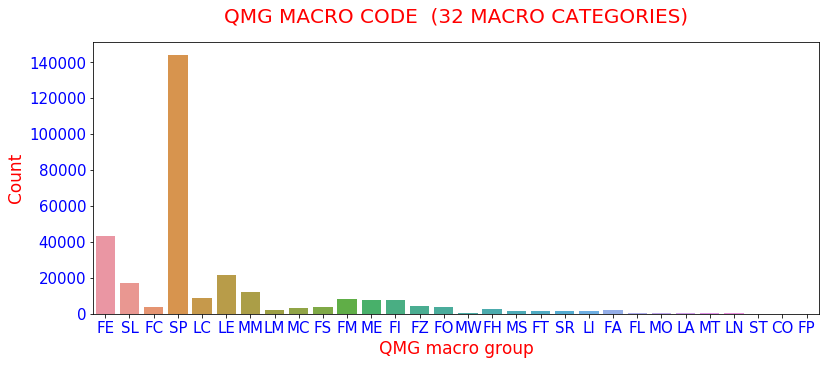

In [30]:
plt.figure(figsize=(13,5))
plt.title('QMG MACRO CODE  (32 MACRO CATEGORIES)', fontsize=20, color= 'r', pad=20)
sns.countplot(macro_qmg)  #, hue= final_aggregated_chiusi['label']
plt.xlabel('QMG macro group', color='r', fontsize= 17)
plt.ylabel('Count', color='r', fontsize= 17)
plt.xticks(color= 'blue', fontsize=15)
plt.yticks(color= 'blue', fontsize=15)
"""legend= plt.legend(fontsize=18, loc= 'upper right')
legend.get_texts()[0].set_text('Non Utilizzati')
legend.get_texts()[1].set_text('Parzialmente utilizzati')
legend.get_texts()[2].set_text('Totalmente utilizzati')"""

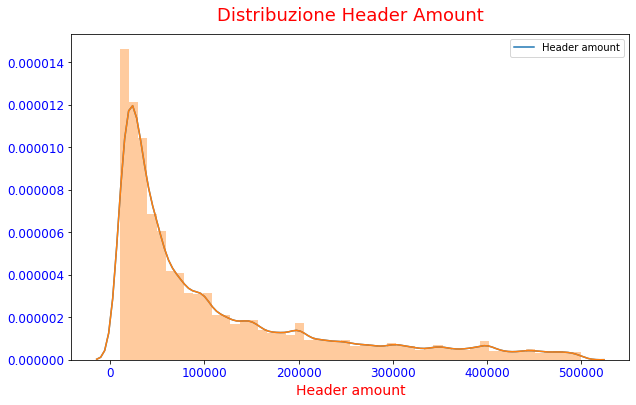

In [33]:
title_ticks_ecc('Distribuzione Header Amount', '', '')
sns.kdeplot(df_rolling_clean_class[df_rolling_clean_class['Header amount']< 500000]['Header amount'] )
sns.distplot(df_rolling_clean_class[df_rolling_clean_class['Header amount']< 500000]['Header amount']) #.hist()

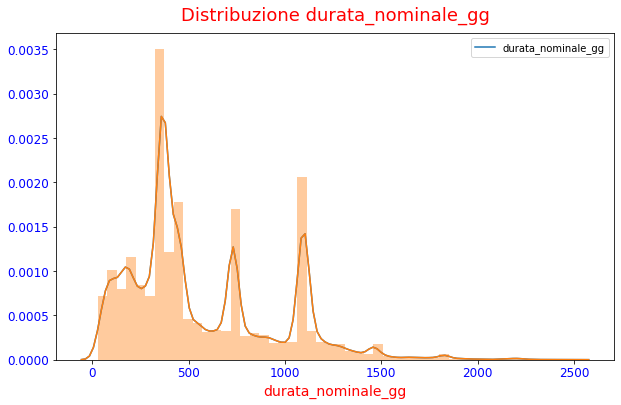

In [34]:
title_ticks_ecc('Distribuzione durata_nominale_gg', '', '')
sns.kdeplot(df_rolling_clean_class['durata_nominale_gg'] )
sns.distplot(df_rolling_clean_class['durata_nominale_gg']) #.hist()

In [35]:
df_rolling_clean_class= df_rolling_clean_class[df_rolling_clean_class['durata_nominale_gg']>=30]
df_rolling_clean_class['label']= df_rolling_clean_class['label'].astype(int) 
df_rolling_clean_class.shape  #(273456, 35)

(304564, 42)

### <center> Descriptive charts on the aggregated dataset (without considering 10 snapshots for each contract)

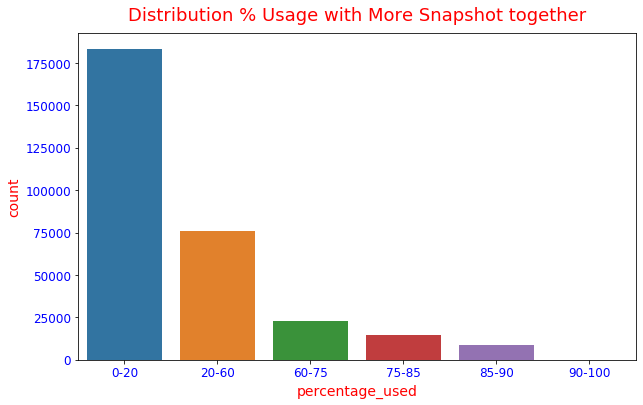

In [36]:
bins= [0, 20, 60, 75, 85, 90, 100]
labels= [ str(bins[i])+ '-' + str(bins[i+1]) for i in range (len(bins)-1)]
distr_labels= pd.cut(df_rolling_clean_class['percentage_used'] , bins= bins, labels= labels, include_lowest=True)

title_ticks_ecc('Distribution % Usage with More Snapshot together', '', '')
sns.countplot(distr_labels)

([<matplotlib.axis.YTick at 0x1929708ca20>,
 <a list of 10 Text yticklabel objects>)

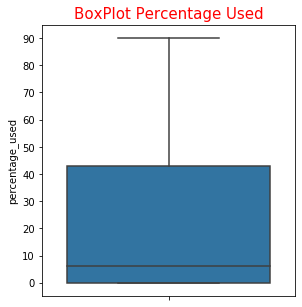

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title('BoxPlot Percentage Used', color='red', fontsize=15)
sns.boxplot(df_rolling_clean_class['percentage_used'],  orient='v')
plt.ylim(-5,95)
plt.yticks(np.arange(0,100, 10, ))

### <font color='green'> N° contratti per life%

In [44]:
samples_per_life= {}

for life in df_rolling_clean_class['life%'].unique():
    samples_per_life[life]= len(df_rolling_clean_class[df_rolling_clean_class['life%']==life])

pd.Series(samples_per_life)

0.0    37797
0.1    34112
0.2    32718
0.3    31720
0.4    30807
0.5    29877
0.6    28857
0.7    27819
0.8    26390
0.9    24467
dtype: int64

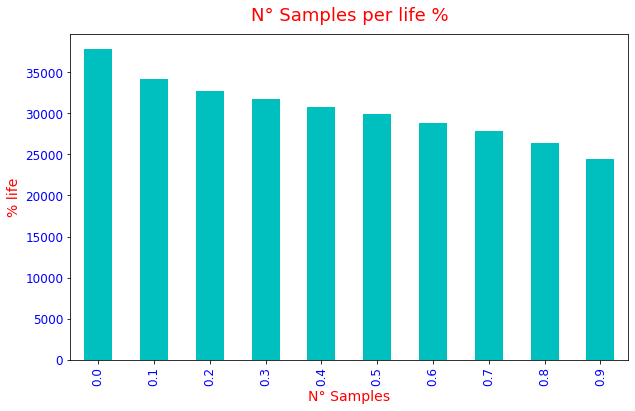

In [45]:
title_ticks_ecc('N° Samples per life %', 'N° Samples', '% life')
pd.Series(samples_per_life).plot(kind='bar', color= 'c')

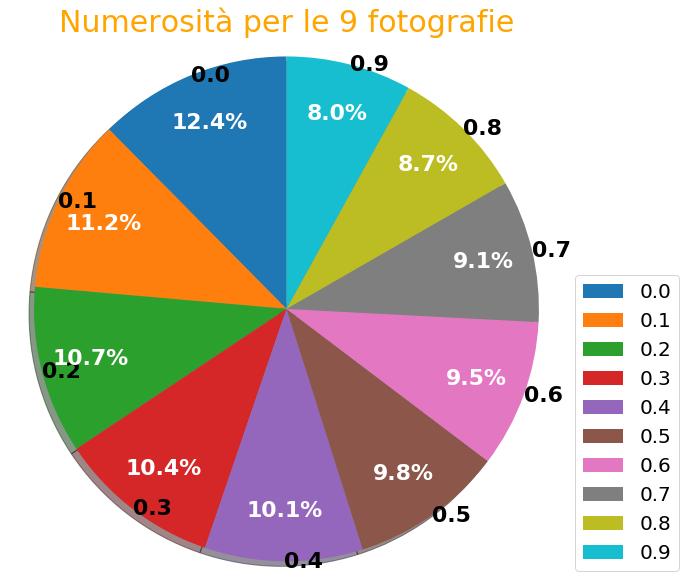

In [46]:
from matplotlib.pyplot import pie, axis, show

sums = df_rolling_clean_class['life%'].value_counts()
#plt.figure(figsize=(20,10))

fig1, ax1 = plt.subplots(figsize= (10,10))
plt.title("Numerosità per le 9 fotografie", fontsize= 30, color='orange')
_, _, autotexts = pie(sums,labels= sums.index, center= (1,1), autopct='%1.1f%%', pctdistance=0.8,
        shadow=True, startangle=90, textprops={'fontsize': 22, 'color':"black", 'weight':'bold'}, labeldistance= 1.0)

for autotext in autotexts:
    autotext.set_color('white')
    
"""ax1.pie(sums, labels=sums.index, center= (1,1), autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 20, 'color':"black"}, labeldistance= 1.0)"""
ax1.axis('equal')
ax1.legend(loc="lower left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=20)
plt.setp(autotexts, weight="bold")
plt.show()

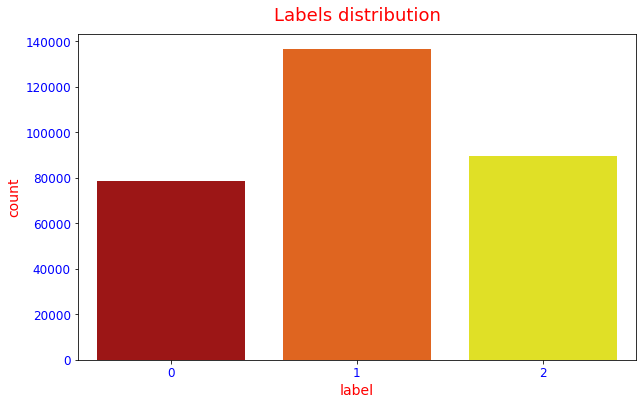

In [47]:
title_ticks_ecc('Labels distribution', 'a', 'b')
sns.countplot(df_rolling_clean_class['label'], palette= 'hot') 

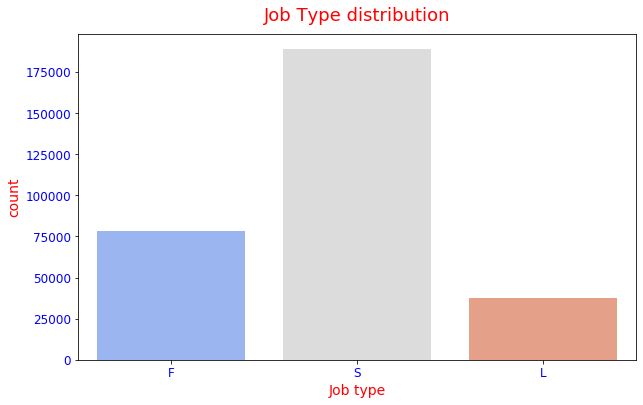

In [48]:
title_ticks_ecc('Job Type distribution', 'a', 'b')
sns.countplot(df_rolling_clean_class['Job type'], palette= 'coolwarm')

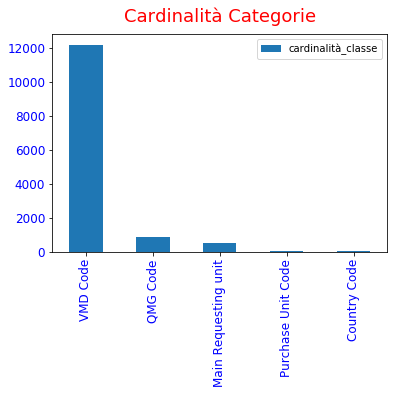

In [49]:
cardinalita.iloc[1:6].plot(kind='bar')  #su tutto il dataset
title_ticks_ecc('Cardinalità Categorie', '', '', new_fig=False )

# <center> Logical Data imputation

<b> N° orders=0; assumptions
* avg amount= 0.
* std amount= 0.   $\quad$ ##since everytime the avg of the amount is 0, also the std must be, if all the single amounts are positive values..
* avg intervals= days_since_beginning+1  $\quad$## it is like saying that the 1st order is done after
* std intervals= 0    $\quad$#there is constancy in not doing them
* days_til_first_order=  days_since_beginning+1
* days_from_last_order= -1 (thus days_til_last_order= days_since_beginning+1)
* orders/month= 0** 

In [54]:
to_impute_0= ['avg_importo_ordine', 'std_importo_ordine', 'std_order_intervals', 'std_order_intervals', ]

for col in to_impute_0:
    df_rolling_clean_class[col]= df_rolling_clean_class.apply(
                                        lambda row: 0 if row['num_orders']== 0 else row[col], axis=1)
    
to_impute_out_range= ['avg_order_intervals', 'days_til_first_order', 'days_til_last_order']

for col in to_impute_out_range:
    df_rolling_clean_class[col]= df_rolling_clean_class.apply( lambda row:
                                row['days_since_beginning']+1 if row['num_orders']== 0 else row[col], axis=1)

<b> N° orders=1; assumptions
* std amount= 0.  
* std intervals= 0  

* other fields remain meaningful as they are

In [56]:
for col in ['std_importo_ordine', 'std_order_intervals']:
    df_rolling_clean_class[col]= df_rolling_clean_class.apply(
                                        lambda row: 0 if row['num_orders']== 1 else row[col], axis=1)

In [57]:
df_rolling_clean_class[feats_create].describe().loc['min']  #apposto

num_orders               0.0
avg_importo_ordine       0.0
std_importo_ordine       0.0
avg_order_intervals      0.0
std_order_intervals      0.0
life%                    0.0
days_since_beginning     0.0
days_til_first_order     0.0
days_til_last_order      0.0
durata_nominale_gg      30.0
percentage_used          0.0
ordini/mese              0.0
label                    0.0
final_used               0.0
True/Ideal Slope         0.0
life%_enc                0.0
gg rimanenti Statico     1.0
orders_trim_1            0.0
orders_trim_2            0.0
orders_trim_3            0.0
orders_trim_4            0.0
initial_trimester        1.0
Accel_orders             0.0
Accel_%used              0.0
Name: min, dtype: float64

### Converting some features to percentages

In [58]:
feats_binarie= binary_feats= booleans= ['Variant code', 'Contract Type', 'Professional services flag', 'Main material group qualification flag']

for col in booleans:
    print(df_rolling_clean_class[col].nunique())

2
2
2
2


In [61]:
df_class= df_rolling_clean_class.copy()
df_class['days_til_first_order']= df_class.apply(lambda row:
    round(100*row['days_til_first_order']/row['durata_nominale_gg'], 3) if row['days_til_first_order']>0 else row['days_til_first_order'], axis=1)

df_class['days_til_first_order'].describe()

count    304564.000000
mean         20.071417
std          22.762093
min           0.000000
25%           3.429000
50%          10.586000
75%          30.046000
max          93.333000
Name: days_til_first_order, dtype: float64

In [64]:
df_class['ordini/mese']= df_class.apply(lambda row: row['num_orders']*30 if row['life%']== 0 else row['ordini/mese'], axis=1)
df_class[df_class['num_orders'] == 0].head()

,Purchase document,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,QMG Code,VMD Code,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Main Requesting unit,Professional services flag,num_orders,avg_importo_ordine,...,std_order_intervals,life%,days_since_beginning,days_til_first_order,days_til_last_order,durata_nominale_gg,percentage_used,ordini/mese,label,final_used,True/Ideal Slope,life%_enc,gg rimanenti Statico,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used
10,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.00,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,0,0.0,...,0.0,0.0,0,0.077,1,1303,0.0,0.0,2,97.81,0.0,0,1166,0.0,0.0,0.0,0.0,4,0.0,0.0
20,EL\5800012593,M&S,Z,S,1,CHL,0,6309437.01,SLVI01,74424,1,S,Estero,CL,CHM,CL,nd,0,0,0.0,...,0.0,0.0,0,0.060,1,1678,0.0,0.0,1,87.50,0.0,0,1678,0.0,0.0,0.0,0.0,3,0.0,0.0
30,DR\9600000478,GIN,Z,F,0,ROP,0,6101934.24,FCCU01,55806,1,S,Estero,RO,ROI,RO,nd,0,0,0.0,...,0.0,0.0,0,0.068,1,1460,0.0,0.0,1,64.02,0.0,0,1460,0.0,0.0,0.0,0.0,4,0.0,0.0
40,CR\8400056435,M&S,Z,S,1,ITA,0,5250000.00,SPPR03,46476,0,R,Centro,IT,AMC,IT,nd,0,0,0.0,...,0.0,0.0,0,0.106,1,941,0.0,0.0,1,28.83,0.0,0,941,0.0,0.0,0.0,0.0,1,0.0,0.0
50,EL\5800012049,M&S,Z,S,0,CHL,0,3772407.71,SLEP03,87042,1,S,Estero,CL,CHM,CL,nd,0,0,0.0,...,0.0,0.0,0,1.724,1,58,0.0,0.0,0,2.21,0.0,0,58,0.0,0.0,0.0,0.0,2,0.0,0.0


In [67]:
def ratio_slopes(row):
    ideal_use= (row['Header amount']* row['days_since_beginning'])/ row['durata_nominale_gg']
    if row['life%']==0:  #se life%=0, days_since beginning pure sono zero e avrei 0 al denominatore
        ideal_use= (row['Header amount']* 1)/ row['durata_nominale_gg']  #perchè è un giorno
    
    actual_use= row['percentage_used']* row['Header amount']  #è gia calcolata sulla base del numero dei giorni
    return round(actual_use/ideal_use, 2)

df_class['True/Ideal Slope']= df_class.apply(ratio_slopes ,axis=1)

In [73]:
############# NEW condition. Ordine mese per quelli allo 0% di vita ###############

df_class['ordini/mese']= df_class.apply(lambda row: 30*row['num_orders'] if (row['life%']== 0) else row['ordini/mese'], axis=1)

In [74]:
### Prima creo giorni da ultimo ordine, come giorni dall inizio - giorni fino all ultimo ordine, poi li metto in %

df_class['days_from_last_order']= df_class.apply(lambda row:
     row['days_since_beginning']- row['days_til_last_order'] if row['days_til_last_order']>0 else row['days_til_last_order'], axis=1)

df_class['days_from_last_order']= df_class.apply(lambda row:
    round(100*row['days_from_last_order']/row['days_since_beginning'], 3) if (
        row['days_from_last_order']>=0 and row['days_since_beginning']>0) else row['days_from_last_order'], axis=1)

df_class['days_from_last_order'].describe()

count    304564.000000
mean         13.919081
std          24.995213
min          -1.000000
25%          -1.000000
50%           0.761000
75%          17.033000
max          99.898000
Name: days_from_last_order, dtype: float64

In [76]:
for col in ['avg_order_intervals', 'std_order_intervals']:
    df_class[col]= df_class.apply(lambda row:
    round(100*row[col]/row['durata_nominale_gg'], 3) if row[col]>=0 else row[col], axis=1)

In [78]:
df_class['avg_importo_ordine']= df_class.apply(lambda row:
    round(100*row['avg_importo_ordine']/row['Header amount'], 3) if row['avg_importo_ordine']>=0 else row['avg_importo_ordine'], axis=1)

df_class['avg_importo_ordine'].describe()

count    304564.000000
mean          7.975744
std          16.717076
min           0.000000
25%           0.000000
50%           0.660000
75%           6.766000
max          89.979000
Name: avg_importo_ordine, dtype: float64

In [79]:
df_class['std_importo_ordine']= df_class.apply(lambda row:
    round(100*row['std_importo_ordine']/row['Header amount'], 3) if row['std_importo_ordine']>=0 else row['std_importo_ordine'], axis=1)

df_class['std_importo_ordine'].describe()

count    304564.000000
mean          1.954392
std           5.247211
min           0.000000
25%           0.000000
50%           0.000000
75%           1.417000
max          62.930000
Name: std_importo_ordine, dtype: float64

In [81]:
df_class.rename({'avg_order_intervals': '%avg_intervals',
                 'std_order_intervals': '%std_intervals',
                'days_from_last_order': '%days_from_last_order',
                'days_til_first_order': '%days_til_first_order',
                 'avg_importo_ordine': '%avg_importo',
                 'std_importo_ordine': '%std_importo' }, inplace= True, axis=1)

df_class.drop(['days_til_last_order', 'days_since_beginning'] ,axis= 1, inplace=True, errors= 'ignore')

df_class.shape  #(304564, 41)

(304564, 41)

In [53]:
feats_create= ['Purchase document',
                 'num_orders',
                 '%avg_importo',
                 '%std_importo',
                 '%avg_intervals',
                 '%std_intervals',
                 'life%',
                 '%days_from_last_order',
                 '%days_til_first_order',
                 'durata_nominale_gg',
                 'percentage_used',
                 'ordini/mese',
                 'label',
                 'True/Ideal Slope',
                 'life%_enc',
                 'gg rimanenti Statico',
                'orders_trim_1', 'orders_trim_2', 'orders_trim_3', 'orders_trim_4', 'initial_trimester',
               'Accel_orders', 'Accel_%used']

In [83]:
df_class['life%']= df_class['life%']*100

### DataSet for Regression

In [7]:
df_reg= df_class[df_class['label']==2]
df_class.shape, df_reg.shape    #((304564, 41), (89596, 41))

((304564, 41), (89596, 41))

### <center> Train Test Split based on Contract ID, rather than row (which is a contract' snapshot)

In [8]:
contr_unici= df_class['Purchase document'].unique()
n_contr_unici= len(contr_unici)

n_contr_unici #35697 contratti unici

37797

In [9]:
np.random.seed(0)
perc_test= 0.15
size_test= round(perc_test*n_contr_unici)
size_test

5670

In [10]:
contr_test = np.random.choice(contr_unici, size= size_test, replace= False)
contr_test

array(['EI\\5300007459', 'EL\\5050006204', 'EL\\5800012409', ...,
       'EL\\5600005597', 'EL\\5600008283', 'DR\\7600002493'], dtype=object)

In [147]:
df_class['label']= df_class['label'].map({0:0, 1:0, 2:1})
df_class['label'].value_counts()

0    214968
1     89596
Name: label, dtype: int64

In [148]:
contr_labels_unique= df_class.groupby(['Purchase document'])['label'].agg({'label' : 'first'})

contr_labels_unique['label'].value_counts() #0    21727, 2    13970

0    21499
1    16298
Name: label, dtype: int64

In [149]:
df_class.shape

(304564, 41)

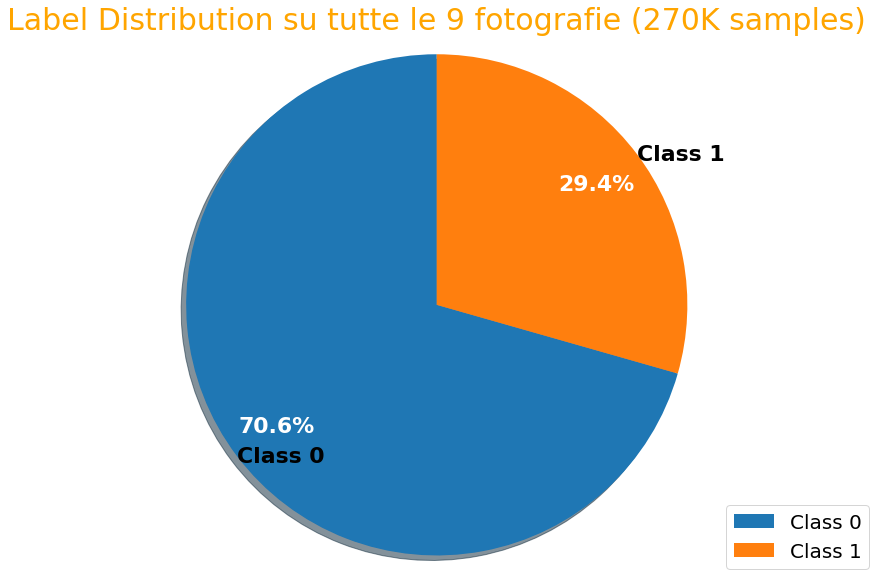

In [150]:
sums = df_class['label'].value_counts()
sums.index= sums.index.map({2: 'Class 2', 1: 'Class 1', 0: 'Class 0'})
#plt.figure(figsize=(20,10))

fig1, ax1 = plt.subplots(figsize= (10,10))
plt.title("Label Distribution su tutte le 10 fotografie (270K samples)", fontsize= 30, color='orange')
_, _, autotexts = pie(sums,labels= sums.index, center= (1,1), autopct='%1.1f%%', pctdistance=0.8,
        shadow=True, startangle=90, textprops={'fontsize': 22, 'color':"black", 'weight':'bold'}, labeldistance= 1.0)

for autotext in autotexts:
    autotext.set_color('white')
    
"""ax1.pie(sums, labels=sums.index, center= (1,1), autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 20, 'color':"black"}, labeldistance= 1.0)"""
ax1.axis('equal')
ax1.legend(loc="lower left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=20)
plt.setp(autotexts, weight="bold")
plt.show()

In [151]:
trimesters_cols= [col for col in df_class.columns if col.startswith('orders_trim')]
binary_cols= ['Variant code', 'Contract Type' , 'Main material group qualification flag', 'Professional services flag']
fake_numerics= ['label', 'final_used','gg rimanenti Statico'] + binary_cols
continuous_cols= [col for col in df_class.select_dtypes(include= 'number').columns if col not in fake_numerics]

"plt.figure(figsize= (20,15))\n\nfor i, trim in enumerate(trimesters_cols):\n    \n    plt.subplot(2, 2, i+1)\n    plt.title(' Trimester {} '.format(trim[-1]), fontsize= 13, color='red')\n    df_class[df_class['label']==0][trim].hist(bins=50, color='orange')\n    plt.xlabel('label', fontsize= 13, color='red')\n    #plt.ylim(-1,4)\n    plt.tight_layout()"

In [152]:
contr_train, contr_test, idx_label_train, idx_label_test= train_test_split(
            contr_labels_unique.index, contr_labels_unique['label'], 
                test_size=0.15, random_state=0 , stratify= contr_labels_unique['label']) #cosi lo fa stratificato

#contr_train['label'].value_counts(), contr_test['label'].value_counts()

## Final Train Test Split

In [155]:
X_train = df_class[df_class['Purchase document'].isin(contr_train)]
X_test = df_class[df_class['Purchase document'].isin(contr_test)]

X_train.shape, X_test.shape #((259053, 41), (45511, 41))

((259053, 41), (45511, 41))

In [156]:
ytrain= X_train['label']
ytest= X_test['label']

print(X_train.shape, X_test.shape)  #(232298, 35) (41158, 35)

X_train.head(3)

(259053, 41) (45511, 41)


,Purchase document,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,QMG Code,VMD Code,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Main Requesting unit,Professional services flag,num_orders,%avg_importo,...,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,final_used,True/Ideal Slope,life%_enc,gg rimanenti Statico,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order
10,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,0,0.000,...,0.077,0.000,0.0,0.077,1303,0.00,0.00,1,97.81,0.00,0,1166,0.000,0.000,0.000,0.0,4,0.000,0.000,-1.0
11,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,1543,0.005,...,0.008,0.077,10.0,2.993,1303,7.68,356.08,1,97.81,76.98,1,1166,0.000,0.000,0.000,0.0,4,1.000,1.000,0.0
12,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,3266,0.005,...,0.008,0.054,20.0,2.993,1303,14.80,376.85,1,97.81,74.17,2,1166,0.419,0.376,0.205,0.0,4,1.117,0.927,0.0


### <center> Handling suppliers (VMD) which have too high cardinality. I work on training and use test for mapping

In [25]:
label='label'
print(df_class.shape)  #(48460, 31)
df_class.head(2)

(304564, 41)


,Purchase document,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,QMG Code,VMD Code,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Main Requesting unit,Professional services flag,num_orders,%avg_importo,...,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,final_used,True/Ideal Slope,life%_enc,gg rimanenti Statico,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order
10,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,0,0.000,...,0.077,0.000,0.0,0.077,1303,0.00,0.00,2,97.81,0.00,0,1166,0.0,0.0,0.0,0.0,4,0.0,0.0,-1.0
11,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,1543,0.005,...,0.008,0.077,10.0,2.993,1303,7.68,356.08,2,97.81,76.98,1,1166,0.0,0.0,0.0,0.0,4,1.0,1.0,0.0


In [26]:
def aggregated_per_VMD(x):
    #'header_utilizzato', 'num_orders', 'total_days_passed'
    d = {}
    d['n_contratti'] = len(x)  #o .count()
    d['n_QMG_unique'] = x['QMG Code'].nunique()
    d['%diff_merchandise']= round(x['QMG Code'].nunique()*100/len(x), 2)
    #d['n_QMG_MACRO_unique'] = x['Macro QMG'].nunique()
    d['Job type'] = x['Job type'].value_counts().to_dict()
    #d['first_contract_date']= min(x['Validity start date'])  #mi interessa quando ha iniziato con Enel
    d['avg header']= round(np.mean(x['Header amount']),2)
    d['std header']= round((np.std(x['Header amount'])), 2)
    d['avg rate mese']= round(np.mean(x['ordini/mese']),2)
    d['std rate mese']= round(np.std(x['ordini/mese']),2)
    d['avg durata nominale']= int(np.mean(x['durata_nominale_gg']))
    d['std durata nominale']= int(np.std(x['durata_nominale_gg']))
    d['avg utilizzo medio']= round(np.mean(x['percentage_used']), 2)
    d['std utilizzo medio']= round(np.std(x['percentage_used']),2)
    
    
    final_list= ['n_contratti', 'n_QMG_unique','%diff_merchandise', 'Job type',
                  'avg header', 'std header', 'avg rate mese', 'std rate mese',
                  'avg durata nominale', 'std durata nominale', 'avg utilizzo medio','std utilizzo medio']
    
    return pd.Series(d, index= final_list)

In [27]:
fornitori_train= X_train.groupby(['VMD Code']).apply(aggregated_per_VMD).sort_values(by= 'n_contratti', ascending=False)

print('Nel training con Random State = 0 i fornitori sono ', len(fornitori_train))  #12318
fornitori_train.head(3)

Nel training con Random State = 0 i fornitori sono  11194


,n_contratti,n_QMG_unique,%diff_merchandise,Job type,avg header,std header,avg rate mese,std rate mese,avg durata nominale,std durata nominale,avg utilizzo medio,std utilizzo medio
VMD Code,,,,,,,,,,,,
46974,522,17,3.26,"{'F': 495, 'S': 27}",44549.75,34526.63,0.61,3.67,645,324,39.93,32.24
1798,470,15,3.19,{'F': 470},4013870.48,13000691.63,0.36,0.60,717,326,23.95,30.84
2215,437,35,8.01,"{'F': 212, 'S': 205, 'L': 20}",935717.74,2005731.28,0.38,1.52,536,321,17.38,27.38


In [28]:
fornitori_train['n° Job type F']= fornitori_train['Job type'].apply(lambda x: x['F'] if 'F' in x else 0)
fornitori_train['n° Job type S']= fornitori_train['Job type'].apply(lambda x: x['S'] if 'S' in x else 0)
fornitori_train['n° Job type L']= fornitori_train['Job type'].apply(lambda x: x['L'] if 'L' in x else 0)

fornitori_train= fornitori_train.drop('Job type', axis=1)
fornitori_train.head()

,n_contratti,n_QMG_unique,%diff_merchandise,avg header,std header,avg rate mese,std rate mese,avg durata nominale,std durata nominale,avg utilizzo medio,std utilizzo medio,n° Job type F,n° Job type S,n° Job type L
VMD Code,,,,,,,,,,,,,,
46974,522,17,3.26,44549.75,34526.63,0.61,3.67,645,324,39.93,32.24,495,27,0
1798,470,15,3.19,4013870.48,13000691.63,0.36,0.60,717,326,23.95,30.84,470,0,0
2215,437,35,8.01,935717.74,2005731.28,0.38,1.52,536,321,17.38,27.38,212,205,20
EI\0000516397,417,5,1.20,111893.77,209467.72,1.98,2.55,377,65,24.18,23.56,0,407,10
46937,417,7,1.68,117050.21,216889.35,0.21,0.31,572,319,30.85,32.09,367,50,0


In [30]:
#fornitori_train['check_avg']= (fornitori_train['sum header']/fornitori_train['n_contratti']).astype(int)

reference_date= datetime(2019, 9, 1, 0, 0)


#fornitori_train['days_from_first_contr']= fornitori_train['first_contract_date'].apply(lambda x:
                                                                        #(reference_date-x).days) #datetime.today()

fornitori_train['%forniture']= fornitori_train.apply(
                               lambda row: round(row['n° Job type F']*100/row['n_contratti'], 2) ,axis=1)

fornitori_train= fornitori_train.drop(['n° Job type F', 'n° Job type S', 'n° Job type L'], axis=1)
fornitori_train.head(2)

,n_contratti,n_QMG_unique,%diff_merchandise,avg header,std header,avg rate mese,std rate mese,avg durata nominale,std durata nominale,avg utilizzo medio,std utilizzo medio,%forniture
VMD Code,,,,,,,,,,,,
46974,522,17,3.26,44549.75,34526.63,0.61,3.67,645,324,39.93,32.24,94.83
1798,470,15,3.19,4013870.48,13000691.63,0.36,0.60,717,326,23.95,30.84,100.00


In [31]:
#Rate di nuovi contratti stipulati in termini di giorni: dopo quanti giorni in media viene fatto nuovo contratto
#fornitori_train['days_for_new_stipulation']= fornitori_train.apply(
                               #lambda row: round(row['days_from_first_contr']/row['n_contratti'], 2) ,axis=1)

In [32]:
fornitori_train['%diff_merchandise']= (fornitori_train['n_QMG_unique']*100/ fornitori_train['n_contratti']).apply(lambda x: round(x,2))
fornitori_train.head(2)

,n_contratti,n_QMG_unique,%diff_merchandise,avg header,std header,avg rate mese,std rate mese,avg durata nominale,std durata nominale,avg utilizzo medio,std utilizzo medio,%forniture
VMD Code,,,,,,,,,,,,
46974,522,17,3.26,44549.75,34526.63,0.61,3.67,645,324,39.93,32.24,94.83
1798,470,15,3.19,4013870.48,13000691.63,0.36,0.60,717,326,23.95,30.84,100.00


In [33]:
fornitori_train= fornitori_train[['n_contratti', 'avg header', 'std header', 'avg rate mese', 'std rate mese', 
                        'avg durata nominale', 'std durata nominale', 'avg utilizzo medio',
                                 'std utilizzo medio', 
                                '%forniture', '%diff_merchandise', ]]

print(fornitori_train.shape ) #(12318, 13)
fornitori_train.head(2)

(11194, 11)


,n_contratti,avg header,std header,avg rate mese,std rate mese,avg durata nominale,std durata nominale,avg utilizzo medio,std utilizzo medio,%forniture,%diff_merchandise
VMD Code,,,,,,,,,,,
46974,522,44549.75,34526.63,0.61,3.67,645,324,39.93,32.24,94.83,3.26
1798,470,4013870.48,13000691.63,0.36,0.60,717,326,23.95,30.84,100.00,3.19


In [34]:
fornitori_train['std header %']= (fornitori_train['std header']*100/fornitori_train['avg header']).apply(lambda x: round(x,2))

# Se non faccio ordini al mese, metto std rate ordini= 0; di fatto sono stabile, nel non farli....
fornitori_train['std rate mese %']= fornitori_train.apply(
    lambda row: round(row['std rate mese']*100/row['avg rate mese'],2) if row['avg rate mese']>0 else 0, axis=1) 

#fornitori_train['std rate mese %']= (fornitori_train['std rate mese']*100/fornitori_train['avg rate mese']).apply(lambda x: round(x,2))
fornitori_train['std durata nominale %']= (fornitori_train['std durata nominale']*100/fornitori_train['avg durata nominale']).apply(lambda x: round(x,2))

final_fornitori_train= fornitori_train.drop(['std header', 'std rate mese', 'std durata nominale'], axis=1) #'n_contratti'
final_fornitori_train= final_fornitori_train[['n_contratti','%forniture', '%diff_merchandise' ,
                                'avg header', 'std header %', 'avg rate mese', 'std rate mese %', 
                                'avg durata nominale', 'std durata nominale %', 'avg utilizzo medio',
                                 'std utilizzo medio']]

final_fornitori_train.iloc[[0,1,-1,-2]]

,n_contratti,%forniture,%diff_merchandise,avg header,std header %,avg rate mese,std rate mese %,avg durata nominale,std durata nominale %,avg utilizzo medio,std utilizzo medio
VMD Code,,,,,,,,,,,
46974,522,94.83,3.26,44549.75,77.50,0.61,601.64,645,50.23,39.93,32.24
1798,470,100.00,3.19,4013870.48,323.89,0.36,166.67,717,45.47,23.95,30.84
48304,1,0.00,100.00,220000.00,0.00,0.00,0.00,781,0.00,0.00,0.00
47842,1,0.00,100.00,145000.00,0.00,0.00,0.00,1098,0.00,0.00,0.00


In [35]:
# li metto a 100% se utilizzato di più
final_fornitori_train['avg utilizzo medio']= final_fornitori_train['avg utilizzo medio'].apply(lambda x: 100 if x>100 else x)
final_fornitori_train.shape  #(12318, 12)

(11194, 11)

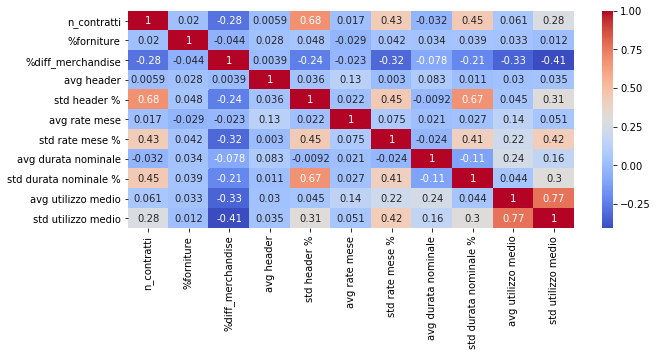

In [40]:
plt.figure(figsize=(10,4))
sns.heatmap(final_fornitori_train.corr(), cmap='coolwarm', annot=True)
plt.show()

In [41]:
final_fornitori_train.head(3)

,n_contratti,%forniture,%diff_merchandise,avg header,std header %,avg rate mese,std rate mese %,avg durata nominale,std durata nominale %,avg utilizzo medio,std utilizzo medio
VMD Code,,,,,,,,,,,
46974,522,94.83,3.26,44549.75,77.50,0.61,601.64,645,50.23,39.93,32.24
1798,470,100.00,3.19,4013870.48,323.89,0.36,166.67,717,45.47,23.95,30.84
2215,437,48.51,8.01,935717.74,214.35,0.38,400.00,536,59.89,17.38,27.38


In [42]:
"""Relazioni tra le features che descrivono fornitori"""

show= False

if show== True:
    sns.pairplot(final_fornitori_train_train[['days_for_new_stipulation', '%diff_merchandise', '%forniture', 'avg header', 'avg rate mese', 'avg utilizzo medio', 'avg durata nominale']])

### <center> Clustering suppliers because too numerous; using percentiles of avg, std of consumption.

In [57]:
custom_metric_train= final_fornitori_train[['n_contratti', 'avg utilizzo medio', 'std utilizzo medio', 'avg header', 'std header %']]
custom_metric_train['%robustezza_utilizzo']= 100-custom_metric_train['std utilizzo medio']
custom_metric_train['%robustezza_utilizzo'].describe()

count    11194.000000
mean        83.697580
std         12.725316
min         55.020000
25%         73.030000
50%         80.495000
75%        100.000000
max        100.000000
Name: %robustezza_utilizzo, dtype: float64

## <center> Threshold: if a supplier does not have at least N contracts, I group them in 'Under Thresh'

In [60]:
soglia= 18

suppliers_train_piu_contr= custom_metric_train[custom_metric_train['n_contratti']>= soglia]
suppliers_train_piu_contr[['n_contratti', 'avg utilizzo medio', '%robustezza_utilizzo']].head()

,n_contratti,avg utilizzo medio,%robustezza_utilizzo
VMD Code,,,
46974,522,39.93,67.76
1798,470,23.95,69.16
2215,437,17.38,72.62
EI\0000516397,417,24.18,76.44
46937,417,30.85,67.91


In [62]:
def combine_categories(colonna_float, lb, ub, n_combined):
    bins= list(map(lambda x: int(x), np.linspace(lb, ub,n_combined)))
    labels= [ str(bins[i])+ '-' + str(bins[i+1]) for i in range (len(bins)-1)]
    return pd.cut(colonna_float , bins= bins, labels= labels, include_lowest=True)

def combine_categories_percentiles(colonna_float):
    colonna_describe= colonna_float.describe()
    bins= [colonna_describe.loc['min'], colonna_describe.loc['25%'], colonna_describe.loc['50%'], colonna_describe.loc['75%'], 100]
    labels= [ str(int(bins[i]))+ '-' + str(int(bins[i+1])) for i in range (len(bins)-1)]
    return pd.cut(colonna_float , bins= bins, labels= labels, include_lowest=True, duplicates='drop')

In [63]:
suppliers_train_piu_contr[['n_contratti', 'avg utilizzo medio', '%robustezza_utilizzo']].describe().T

,count,mean,std,min,25%,50%,75%,max
n_contratti,4080.0,48.917892,48.520113,18.00,20.0000,30.000,57.0000,522.00
avg utilizzo medio,4080.0,22.702375,14.417034,0.00,12.2900,21.815,32.4625,77.99
%robustezza_utilizzo,4080.0,77.827233,10.046173,55.33,71.0375,75.440,82.4625,100.00


In [64]:
suppliers_train_under_thresh= custom_metric_train.drop(suppliers_train_piu_contr.index)
suppliers_train_under_thresh[['n_contratti', 'avg utilizzo medio', 'avg header']].describe()

,n_contratti,avg utilizzo medio,avg header
count,7114.000000,7114.000000,7.114000e+03
mean,8.359292,19.605600,5.618072e+05
std,3.574274,20.754116,3.845998e+06
min,1.000000,0.000000,1.000000e+04
25%,7.000000,0.000000,3.900000e+04
50%,10.000000,14.425000,8.956182e+04
75%,10.000000,36.190000,2.748734e+05
max,17.000000,89.830000,1.677951e+08


### Gestisco quelli con n_contratti>= soglia

In [66]:
describe_avg_utilizzo_under = suppliers_train_under_thresh['avg utilizzo medio'].describe() 
describe_avg_utilizzo_under

count    7114.000000
mean       19.605600
std        20.754116
min         0.000000
25%         0.000000
50%        14.425000
75%        36.190000
max        89.830000
Name: avg utilizzo medio, dtype: float64

In [67]:
describe_utilizzo_piu_contr = suppliers_train_piu_contr[['avg utilizzo medio', '%robustezza_utilizzo']].describe() 
describe_utilizzo_piu_contr

,avg utilizzo medio,%robustezza_utilizzo
count,4080.000000,4080.000000
mean,22.702375,77.827233
std,14.417034,10.046173
min,0.000000,55.330000
25%,12.290000,71.037500
50%,21.815000,75.440000
75%,32.462500,82.462500
max,77.990000,100.000000


In [68]:
############ Fasce Utilizzo################
suppliers_train_piu_contr['% utilizzo per fasce']= combine_categories_percentiles(suppliers_train_piu_contr['avg utilizzo medio'])

############### Fasce Robustezza ###################

    
#suppliers_train_piu_contr['% robustezza per fasce']= combine_categories_percentiles(suppliers_train_piu_contr['%robustezza_utilizzo']) 

bins=[describe_utilizzo_piu_contr['%robustezza_utilizzo'].loc['min'], describe_utilizzo_piu_contr['%robustezza_utilizzo'].loc['mean'] ,
      describe_utilizzo_piu_contr['%robustezza_utilizzo'].loc['max']]

suppliers_train_piu_contr['% robustezza per fasce']= pd.cut(
            suppliers_train_piu_contr['%robustezza_utilizzo'], bins=bins, labels=[
                    str(int(bins[i]))+ '-' + str(int(bins[i+1])) for i in range (len(bins)-1) ], include_lowest=True)

suppliers_train_piu_contr.head()

,n_contratti,avg utilizzo medio,std utilizzo medio,avg header,std header %,%robustezza_utilizzo,% utilizzo per fasce,% robustezza per fasce
VMD Code,,,,,,,,
46974,522,39.93,32.24,44549.75,77.50,67.76,32-100,55-77
1798,470,23.95,30.84,4013870.48,323.89,69.16,21-32,55-77
2215,437,17.38,27.38,935717.74,214.35,72.62,12-21,55-77
EI\0000516397,417,24.18,23.56,111893.77,187.20,76.44,21-32,55-77
46937,417,30.85,32.09,117050.21,185.30,67.91,21-32,55-77


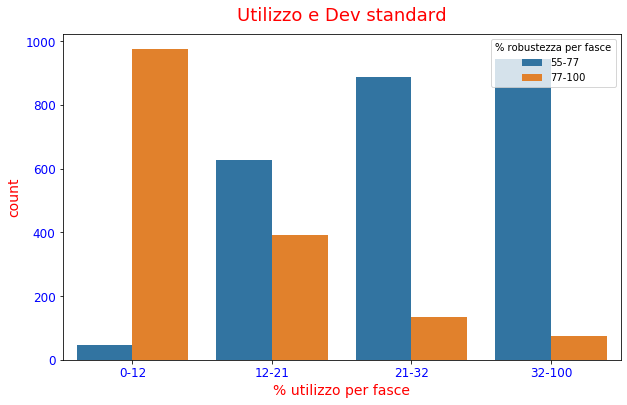

In [69]:
title_ticks_ecc('Utilizzo e Dev standard', '', '')
sns.countplot(suppliers_train_piu_contr['% utilizzo per fasce'], hue= suppliers_train_piu_contr['% robustezza per fasce'] ) #dodge=False

In [70]:
import itertools

########### Combinazioni avg utilizzo - std dev utilizzo di quelli con n° contratti superiore a soglia
combinations_piu= [list(suppliers_train_piu_contr['% utilizzo per fasce'].unique()), list(suppliers_train_piu_contr['% robustezza per fasce'].unique())]
combinations_piu= list(itertools.product(*combinations_piu))
combinations_piu

[('32-100', '55-77'),
 ('32-100', '77-100'),
 ('21-32', '55-77'),
 ('21-32', '77-100'),
 ('12-21', '55-77'),
 ('12-21', '77-100'),
 ('0-12', '55-77'),
 ('0-12', '77-100')]

In [71]:
combinations_piu.pop(6)  # tolgo gruppo ('0-14', '55-78'), troppo poco popolato
combinations_piu

[('32-100', '55-77'),
 ('32-100', '77-100'),
 ('21-32', '55-77'),
 ('21-32', '77-100'),
 ('12-21', '55-77'),
 ('12-21', '77-100'),
 ('0-12', '77-100')]

In [72]:
diz_combinations_suppl_piu= {}
n_groups_piu= 7

for i in range (n_groups_piu):
    diz_combinations_suppl_piu['group' + str(i)]= combinations_piu[i]

threshold= soglia
    
diz_combinations_suppl_piu= pd.DataFrame(diz_combinations_suppl_piu).T
diz_combinations_suppl_piu.columns= ['% utilizzo', '% robustezza (100%- std utilizzo%)']
diz_combinations_suppl_piu['n_contratti']= [str(threshold) + '+']*n_groups_piu
diz_combinations_suppl_piu

,% utilizzo,% robustezza (100%- std utilizzo%),n_contratti
group0,32-100,55-77,18+
group1,32-100,77-100,18+
group2,21-32,55-77,18+
group3,21-32,77-100,18+
group4,12-21,55-77,18+
group5,12-21,77-100,18+
group6,0-12,77-100,18+


### Gestisco quelli con n° contratti< threshold, li metto tutti in un unico gruppo

In [73]:
diz_group_uder_thresh= pd.DataFrame({'Under_thresh': ['Not defined', 'Not defined', '<' + str(threshold)]}).T
diz_group_uder_thresh.columns= diz_combinations_suppl_piu.columns

suppliers_train_under_thresh.shape #(6982, 6)

(7114, 6)

In [75]:
summary_groups_suppliers= pd.concat([diz_combinations_suppl_piu, diz_group_uder_thresh])
summary_groups_suppliers

,% utilizzo,% robustezza (100%- std utilizzo%),n_contratti
group0,32-100,55-77,18+
group1,32-100,77-100,18+
group2,21-32,55-77,18+
group3,21-32,77-100,18+
group4,12-21,55-77,18+
group5,12-21,77-100,18+
group6,0-12,77-100,18+
Under_thresh,Not defined,Not defined,<18


In [76]:
suppliers_train_under_thresh['group']= ['Under_thresh']* len(suppliers_train_under_thresh)
suppliers_train_under_thresh.head()

,n_contratti,avg utilizzo medio,std utilizzo medio,avg header,std header %,%robustezza_utilizzo,group
VMD Code,,,,,,,
107634,17,15.88,23.46,520116.04,2.08,76.54,Under_thresh
64168,17,32.48,33.62,1063142.53,75.42,66.38,Under_thresh
110100,17,11.73,25.84,66831.82,0.16,74.16,Under_thresh
25530,17,45.48,26.99,882082.35,36.24,73.01,Under_thresh
67599,17,17.05,22.18,537925.29,47.29,77.82,Under_thresh


In [79]:
def fasce_fornitori_percentili(row):  
    
    for i, tupla in enumerate(combinations_piu):
    ## Se è 0-13, lo metto a prescindere nel gruppo 6, sennò rischio di fare gruppo poco numeroso come visto prima
        if row['% utilizzo per fasce']== tupla[0]:
            if tupla[0]== combinations_piu[-1][0]:  # utilizzo '0-13'
                return 'group6'
            else:
                if row['% robustezza per fasce']== tupla[1]:
                    return 'group' + str(i)

In [80]:
suppliers_train_piu_contr['group']= suppliers_train_piu_contr.apply(lambda row: fasce_fornitori_percentili(row), axis=1)
suppliers_train_piu_contr.sample(2)

,n_contratti,avg utilizzo medio,std utilizzo medio,avg header,std header %,%robustezza_utilizzo,% utilizzo per fasce,% robustezza per fasce,group
VMD Code,,,,,,,,,
181350,20,0.00,0.00,53877.41,59.37,100.00,0-12,77-100,group6
94966,28,20.01,25.76,712102.71,145.25,74.24,12-21,55-77,group4


In [83]:
fasce_ut= ['Not def']* len(suppliers_train_under_thresh)
fasce_Std= ['Not def']* len(suppliers_train_under_thresh)

if "% utilizzo per fasce" not in suppliers_train_under_thresh.columns:
    suppliers_train_under_thresh.insert (7, "% utilizzo per fasce", fasce_ut) 
    
if "% robustezza per fasce" not in suppliers_train_under_thresh.columns:
    suppliers_train_under_thresh.insert (8, "% robustezza per fasce", fasce_ut) 

In [84]:
suppliers_train_final= pd.concat([suppliers_train_under_thresh, suppliers_train_piu_contr])
suppliers_train_final.sample(8)

,% robustezza per fasce,% utilizzo per fasce,%robustezza_utilizzo,avg header,avg utilizzo medio,group,n_contratti,std header %,std utilizzo medio
VMD Code,,,,,,,,,
2496,77-100,0-12,100.00,168049.26,0.00,group6,27,63.63,0.00
40259,Not def,Not def,79.71,490900.50,50.52,Under_thresh,10,0.00,20.29
129703,77-100,0-12,92.35,239153.57,3.04,group6,20,4.97,7.65
2979,Not def,Not def,100.00,55513.69,0.00,Under_thresh,2,0.00,0.00
67118,77-100,12-21,79.40,1394676.93,17.84,group5,60,74.59,20.60
28137,Not def,Not def,74.40,683437.50,30.46,Under_thresh,7,0.00,25.60
63390,Not def,Not def,79.42,512166.67,13.70,Under_thresh,12,35.29,20.58
50381,Not def,Not def,74.74,68176336.70,36.96,Under_thresh,9,0.00,25.26


In [86]:
diz_suppl_convertion= dict(zip(suppliers_train_final.index, suppliers_train_final['group'].values))
len(diz_suppl_convertion) #10897 V

11194

### Adding new combined categorical variable for suppliers to train and test

In [87]:
X_train['supplier_class']= X_train['VMD Code'].map(diz_suppl_convertion)

print(X_train.shape, '\n\n', X_train['supplier_class'].value_counts()) #(131469, 34)

(259053, 42) 

 Under_thresh    59468
group2          54068
group4          41387
group6          38030
group0          37003
group5          22648
group3           4609
group1           1840
Name: supplier_class, dtype: int64


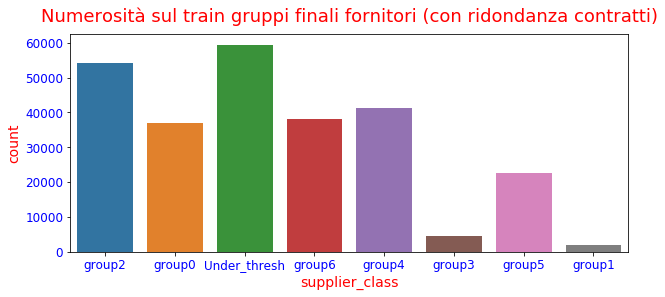

In [88]:
title_ticks_ecc('Numerosità sul train gruppi finali fornitori (con ridondanza contratti)' , '', '',figsize= (10,4))
sns.countplot(X_train['supplier_class'])
#plt.ylim(0, 17000)

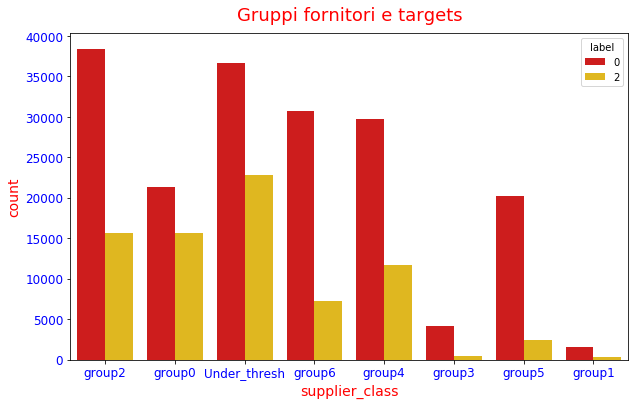

In [89]:
# Plotto
title_ticks_ecc('Gruppi fornitori e targets', 'a', 'b')
sns.countplot(X_train['supplier_class'], hue= X_train['label'], palette= 'hot') 

In [90]:
X_train.head(3)  #X_train è per modello statico

,Purchase document,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,QMG Code,VMD Code,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Main Requesting unit,Professional services flag,num_orders,%avg_importo,...,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,final_used,True/Ideal Slope,life%_enc,gg rimanenti Statico,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,supplier_class
10,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,0,0.000,...,0.000,0.0,0.077,1303,0.00,0.00,2,97.81,0.00,0,1166,0.000,0.000,0.000,0.0,4,0.000,0.000,-1.0,group2
11,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,1543,0.005,...,0.077,10.0,2.993,1303,7.68,356.08,2,97.81,76.98,1,1166,0.000,0.000,0.000,0.0,4,1.000,1.000,0.0,group2
12,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,nd,0,3266,0.005,...,0.054,20.0,2.993,1303,14.80,376.85,2,97.81,74.17,2,1166,0.419,0.376,0.205,0.0,4,1.117,0.927,0.0,group2


In [92]:
def convert_suppl_test(row):
    try:
        return diz_suppl_convertion[row['VMD Code']]
    except:
        return 'Unseen Supplier'

X_test['supplier_class']= X_test.apply(convert_suppl_test, axis=1)

X_test.head()

,Purchase document,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,QMG Code,VMD Code,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Main Requesting unit,Professional services flag,num_orders,%avg_importo,...,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,final_used,True/Ideal Slope,life%_enc,gg rimanenti Statico,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,supplier_class
80,EL\5800012947,M&S,Z,L,0,COL,0,2798777.58,LCCC13,61971,1,S,Estero,CO,COM,CO,nd,0,0,0.000,...,0.000,0.0,0.091,1095,0.00,0.00,2,97.12,0.00,0,771,0.000,0.000,0.000,0.000,3,0.000,0.000,-1.000,Under_thresh
81,EL\5800012947,M&S,Z,L,0,COL,0,2798777.58,LCCC13,61971,1,S,Estero,CO,COM,CO,nd,0,3,0.897,...,3.790,10.0,8.037,1095,2.69,0.83,2,97.12,27.02,1,771,0.000,0.000,0.000,0.000,3,1.000,1.000,19.266,Under_thresh
82,EL\5800012947,M&S,Z,L,0,COL,0,2798777.58,LCCC13,61971,1,S,Estero,CO,COM,CO,nd,0,29,0.777,...,1.799,20.0,8.037,1095,22.53,3.97,2,97.12,112.65,2,771,0.172,0.000,0.000,0.828,3,8.667,7.375,12.329,Under_thresh
83,EL\5800012947,M&S,Z,L,0,COL,0,2798777.58,LCCC13,61971,1,S,Estero,CO,COM,CO,nd,0,41,0.773,...,1.872,30.0,8.037,1095,31.70,3.75,2,97.12,105.83,3,771,0.122,0.268,0.024,0.585,3,0.462,0.462,0.915,Under_thresh
84,EL\5800012947,M&S,Z,L,0,COL,0,2798777.58,LCCC13,61971,1,S,Estero,CO,COM,CO,nd,0,60,0.812,...,1.635,40.0,8.037,1095,48.74,4.11,2,97.12,121.85,4,771,0.083,0.183,0.250,0.483,3,1.583,1.858,0.228,Under_thresh


## <center> Handling Categorical Variables: either OHE or Custom Target Encoding

In [161]:
common_cols_to_drop= ['Active contract flag', 'Main Requesting unit', 'life%_enc'] 


DIRECT_ENCODING = True
DUMMIES= False
                                
if DIRECT_ENCODING == False:
    common_cols_to_drop= common_cols_to_drop + ['VMD Code']
    
else:  #If I want direct encoding
    common_cols_to_drop=  common_cols_to_drop + ['supplier_class']

"if DIRECT_ENCODING == False:\n    common_cols_to_drop= common_cols_to_drop + ['VMD Code']\n    \nelse:  #Se voglio Encoding diretto\n    common_cols_to_drop=  common_cols_to_drop + ['supplier_class']"

In [164]:
X_train= X_train.drop(common_cols_to_drop, axis=1, errors='ignore') #per class
X_test = X_test.drop(common_cols_to_drop, axis=1, errors='ignore')  #per class

X_train.shape, X_test.shape #((259053, 40), (45511, 40))

((259053, 39), (45511, 39))

In [166]:
REMOVE_TARGET_REG= False
if REMOVE_TARGET_REG:
    for X in [X_train, X_test]:
        X.drop('gg rimanenti Statico', axis=1, inplace= True, errors='ignore')

X_train.head(2)

,Purchase document,Global Business line,Purchase document type,Job type,Variant code,Global Purchase Unit Code,Contract Type,Header amount,QMG Code,VMD Code,Main material group qualification flag,Supplier Type Code,Geographical Area,Country Code,Purchase Unit Code,Purchase Country Code,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,final_used,True/Ideal Slope,gg rimanenti Statico,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order
10,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,0,0,0.000,0.000,0.077,0.000,0.0,0.077,1303,0.00,0.00,1,97.81,0.00,1166,0.0,0.0,0.0,0.0,4,0.0,0.0,-1.0
11,DI\8400060305,GIN,Z,F,1,ITA,0,9800000.0,FEMI01,10749,0,S,Nord,IT,APR,IT,0,1543,0.005,0.009,0.008,0.077,10.0,2.993,1303,7.68,356.08,1,97.81,76.98,1166,0.0,0.0,0.0,0.0,4,1.0,1.0,0.0


In [167]:
X_sets_class=  [X_train, X_test]

for X in X_sets_class:
    print(X.shape)    #"""(232298, 30)( 41158, 30)(67854, 31)(12133, 31)"""

(259053, 39)
(45511, 39)


In [169]:
REMOVE_SUP_CLASS= False
if REMOVE_SUP_CLASS:
    for X in X_sets_class:
        X.drop('supplier_class', axis=1, errors='ignore', inplace= True)

X_train.shape, X_test.shape #((226770, 33), (39997, 33))

((259053, 39), (45511, 39))

### Transforming Regression Target in %Life (effective days duration/nominal duration)

In [173]:
for X in [X_train, X_test]:
    #X.drop('label', axis=1, inplace=True, errors='ignore')
    if 'gg rimanenti Statico' in X.columns:
        print('...converting in target...')
        X['Target%']= X.apply(
                                lambda row: round( (100*row['gg rimanenti Statico'])/row['durata_nominale_gg'],2), axis=1)
        X.rename({'gg rimanenti Statico': 'target'}, inplace= True, axis=1)
        X.drop('target', axis=1, inplace= True)
    else:
        print('There is already Target column')
    if 'final_used' in X.columns:
        print('Converting Classification Target Name')
        X.rename({'final_used': 'target_class'}, inplace= True, axis=1)

X_train.shape, X_test.shape #((226770, 32), (39997, 32))

...converting in target...
Converting Classification Target Name
...converting in target...
Converting Classification Target Name


((259053, 39), (45511, 39))

In [258]:
X_train_reg= X_train[X_train['label']==1]
X_test_reg= X_test[X_test['label']==1]

X_train.shape, X_train_reg.shape #((259053, 39), (76326, 39))

((259053, 39), (76326, 39))

# <center> Custom K-Fold Target Encoding with Noise

In [113]:
class KFoldTargetEncoderTrain_std(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=10,verbosity=True,discardOriginal_col=False, threshold= 1, showPrint= False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        self.threshold= threshold
        self.showPrint= showPrint

    def fit(self, X, y=None):
        return self

    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        assert(type(self.threshold) == int)
       
        kf = KFold(n_splits = self.n_fold, shuffle = False, random_state=2019)
        #kf = StratifiedKFold(n_splits = self.n_fold, shuffle = False, random_state=2019)

        col_mean_name = self.colnames + '_' + 'enc_mean'
        col_std_name= self.colnames + '_' + 'enc_std'
        
        #Le inizializzo con tutti NaN
        X[col_mean_name] = np.nan
        X[col_std_name] = np.nan
        
        #A ogni giro (per ogni K-Fold) fillo valori della Test Fold con la media delle Train Fold.
        for tr_ind, val_ind in kf.split(X):
            if self.showPrint is True:
                print('Indici delle Train-Folds: {},\033[1mTest Fold da fillare: {}\033[0m \n'.format(tr_ind, val_ind))  #sono gli indici delle folds

            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]

            diz_mean= X_tr.groupby(self.colnames)[self.targetName].mean().to_dict()
            diz_std= X_tr.groupby(self.colnames)[self.targetName].std().to_dict()

            #### Tratto come Nan chi non supera la threshold, agli altri assegno media e std sulle altre folds
            frequenze= X_tr.groupby(self.colnames).size()
            cat_oltre_threshold= frequenze[frequenze >= self.threshold].index
            
            if self.showPrint == True:
                print('cat_oltre_threshold', cat_oltre_threshold)

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].apply(lambda x: diz_mean[x] if x in cat_oltre_threshold else np.nan )
            X.loc[X.index[val_ind], col_std_name] = X_val[self.colnames].apply(lambda x: diz_std[x] if x in cat_oltre_threshold else np.nan)

            mean_of_target = X_tr[self.targetName].mean()  #media di tutto il target sul KFold Train, not grouped
            std_of_target= X_tr[self.targetName].std()    # # std di tutto il target sul KFold Train, not grouped

            X[col_mean_name].fillna(mean_of_target, inplace = True) #ai NaN metto la media del KFold Train Target
            X[col_std_name].fillna(std_of_target, inplace = True)   # ai NaN metto la std dev media del Kfold Train Target

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                    self.targetName,np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            if self.showPrint == True:
                print('columns: ', X.columns)
            X = X.drop(self.colnames, axis=1)
        return X
    
    
class KFoldTargetEncoderTest_std(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,Train_encoded_mean, Train_encoded_std, showPrint= False):
        
        self.train = train
        self.colNames = colNames
        self.Train_encoded_mean = Train_encoded_mean
        self.Train_encoded_std = Train_encoded_std
        self.showPrint= showPrint
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):

        ### Media e std del Target grouped per categoria su tutto il Train
        category_mean_tr = self.train[[self.colNames,self.Train_encoded_mean]].groupby(self.colNames).mean() #.reset_index() 
        category_std_tr= self.train[[self.colNames,self.Train_encoded_std]].groupby(self.colNames).mean() #.reset_index() 
        
        ### Media dell'Encoding basato su mean e std sul Train (non grouped per categoria)
        population_mean_tr= self.train[self.Train_encoded_mean].mean()
        population_std_tr= self.train[self.Train_encoded_std].mean()
        
        ### Metto nel Test i valori medi della mean e std del Train per quella categoria
        X[self.Train_encoded_mean]= X[self.colNames].map(category_mean_tr.squeeze().to_dict())
        X[self.Train_encoded_std]= X[self.colNames].map(category_std_tr.squeeze().to_dict())
        
        ### Fillo i Missing Values (Categorie Nuove) con i valori medi di mean e std (encodate) di tutte la variabile nel Train
        if self.showPrint== True:
            print('Filled {} Missing Values with Average mean and std equals to {}, {}'.format(
                                                        np.sum(np.sum(X.isna())), population_mean_tr , population_std_tr))
        
        X[self.Train_encoded_mean].fillna(population_mean_tr, inplace = True) #fillo con media di enc_mean sul Train
        X[self.Train_encoded_std].fillna(population_std_tr, inplace = True)   #fillo con media di enc_std sul Train
        
        return X

In [265]:
X_train_usage= X_train.drop('Target%', axis=1, errors= 'ignore')
X_test_usage= X_test.drop('Target%', axis=1, errors= 'ignore')

X_train_time= X_train.drop('target_class', axis=1, errors= 'ignore')
X_test_time= X_test.drop('target_class', axis=1, errors= 'ignore')

########## X_train_reg è l unico filtrato per label=1 ###############
X_train_reg= X_train_reg.drop('target_class', axis=1, errors= 'ignore')
X_test_reg= X_test_reg.drop('target_class', axis=1, errors= 'ignore')

In [1]:
def encoding_cat_noise(xtrain_orig, xtest_orig, target= 'Target%', verbose= False, minimum_std= 0.1, n_folds=200, 
                              prop_std_per_noise= 0.05, threshold= 10, showPrint= False, cols_to_encode= None):
    
    """return diz={'scaled_train': scaled_train, 'scaled_test': scaled_test, 'ytrain': ytrain, 'ytest': ytest}
       task= ['class', 'reg']"""
    
    np.random.seed(42)
    label= target  #naming convention
    
    xtrain= xtrain_orig.copy()
    xtest= xtest_orig.copy()
    ytrain= xtrain[label]  
    ytest=  xtest[label]   
    
    print('Train and Test initial shapes (including target): ', xtrain.shape, xtest.shape)
    print('Threshold is: ', threshold)
    #purch_doc_train= xtrain['Purchase document']
    #purch_doc_test= xtest['Purchase document']
    #xtrain= xtrain.drop('Purchase document', axis=1)
    #xtest= xtest.drop('Purchase document', axis=1)
    
    
    #Faccio Encoding di tutte quelle di tipo Oggetto, cioè stringe
    cardinalita_Xtrain={}
    for col in xtrain.drop('Purchase document', axis=1).select_dtypes(include=[object]).columns:
        cardinalita_Xtrain[col]= xtrain[col].nunique()
    cardinalita_Xtrain= pd.Series(cardinalita_Xtrain)
    cardinalita_Xtrain= cardinalita_Xtrain.sort_values(ascending=False)
    cardinalita_Xtrain= pd.DataFrame(cardinalita_Xtrain, columns= ['cardinalità_classe'])
    cardinalita_Xtrain


    columns_to_encode= list(cardinalita_Xtrain.index)
    if cols_to_encode is not None:  #le cambio solo se glielo specifico, sennò lo faccio per tutti i dtypes= object
        columns_to_encode= cols_to_encode
    
    print('...Performing Encoding...')
    for col in columns_to_encode:
        if showPrint== True:
            print('\n COLUMN NAME: ', col)  
        targetc = KFoldTargetEncoderTrain_std(col, label ,n_fold= n_folds, verbosity= verbose,threshold = threshold, showPrint= False)
        xtrain = targetc.fit_transform(xtrain)
        #print(xtrain.iloc[:2, 17:], '\n')

        test_targetc = KFoldTargetEncoderTest_std(xtrain,col, col+ '_enc_mean', col+ '_enc_std')
        xtest= test_targetc.fit_transform(xtest)
        
        xtrain= xtrain.drop(col, axis=1)
        xtest= xtest.drop(col, axis=1)
    print('...Encoding Terminated...')
        
    xtrain= xtrain.drop( [label], axis=1)
    xtest= xtest.drop([label], axis=1)
             
    #### Metto minimum_std dev a chi ha 0, così poi ci sarà un po' di Noise pure in corrispondenza di quei samples
    cols_std= [col for col in xtrain.columns if col.split('_')[-1]== 'std']
    
    for col in cols_std:
        xtrain[col]= xtrain[col].apply(lambda x: minimum_std if x==0 else x)
        xtest[col]= xtest[col].apply(lambda x: minimum_std if x==0 else x)
        
    #for col in cols_std:
        #print('Ci sono {} std = 0 per colonna {}'.format(xtrain[col][xtrain[col]== 0].sum(), col))
    
    ###### Final Encoding con Noise #########
    cols_mean= [col for col in xtrain.columns if col.split('_')[-1]== 'mean']
    diz_mean_std= dict(zip(cols_mean, [col[: len(col)- len('mean')] +'std' for col in cols_mean] ))
    
    for key in diz_mean_std.keys():  #key è la colonna con la media
        #if showPrint== True:
            #print(' key and value are: ', key, diz_mean_std[key] ) 
        for X in [xtrain, xtest]:   # Creo colonna con encoding finale e droppo le due di mean e std encoding
            ### Metto Noise sono nel Training. Nel test solo medie.
            if X is xtrain:   
                X[key[: - len('_enc_mean')] + '_FINAL_ENC' ] = np.random.normal(X[key], prop_std_per_noise* X[diz_mean_std[key]], len(X))
            elif X is xtest:
                X[key[: - len('_enc_mean')] + '_FINAL_ENC' ]= X[key]  #key è la colonna con la media
            X.drop([key, diz_mean_std[key]], axis=1, inplace= True)
                
    ##### Faccio dei Check #####
    if len(xtrain.select_dtypes(include=object).columns) ==1 and len(xtest.select_dtypes(include=object).columns) ==1:
        print('\n \033[1mCORRETTO: Tutte colonne sono numeriche, a parte Purchase Doc!!\033[0m')
    else:
        print('\n \033[1mSBAGLIATO: n° colonne non numeriche non è 1 (Purchase Doc), ma ', max(len(xtrain.select_dtypes(include=object).columns),  
                                                                                   len(xtest.select_dtypes(include=object).columns)))
        
        
    ### Ultimo check: colonne Train e Test devono essere uguali
    if list(xtrain.columns) != list(xtest.columns): 
        print('ERRORE: COLONNE IN TRAIN E TEST SONO DIVERSE')
        
    #Gli rimetto Purchase Document, solo per andare in Join dopo
    #xtrain.insert (0, "Purchase document", purch_doc_train)
    #xtest.insert(0, "Purchase document", purch_doc_test)
    
    #numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    time_init= time.time()
    for x in [xtrain, xtest]:
        if x.index.name != 'Purchase document':
            x.set_index('Purchase document', inplace= True)
        for col in x.select_dtypes(include= 'float64'):  #include='numerics'
            x[col]= x[col].apply(lambda x: round(x, 4))
    print('execution time (min) for rounding=', round((time.time()-time_init)/60, 1))
        
    print('\n Train and Test final shapes: ', xtrain.shape, xtest.shape)
        
    return {'X_train': xtrain, 'X_test': xtest, 'ytrain': ytrain, 'ytest': ytest}

In [10]:
np.random.seed(42)
np.random.normal(0, 1*0.05)

0.024835707650561634

<b> Encoding for Classification

In [124]:
thresh_class= 30 #ho 10 righe per contratto, cosi impongo praticamente 3 doppioni di ognuno...
#Final shapes: (130240, 29) (23001, 29)
container_class= encoding_cat_noise(X_train_usage, X_test_usage, target= 'target_class', n_folds= 100, minimum_std= 1, 
                                    prop_std_per_noise= 0.05, threshold= thresh_class, showPrint= True)

Train and Test initial shapes (including target):  (259053, 38) (45511, 38)
Threshold is:  30
...Performing Encoding...

 COLUMN NAME:  VMD Code

 COLUMN NAME:  QMG Code

 COLUMN NAME:  Purchase Unit Code

 COLUMN NAME:  Country Code

 COLUMN NAME:  Purchase Country Code

 COLUMN NAME:  Global Purchase Unit Code

 COLUMN NAME:  supplier_class

 COLUMN NAME:  Global Business line

 COLUMN NAME:  Geographical Area

 COLUMN NAME:  Supplier Type Code

 COLUMN NAME:  Purchase document type

 COLUMN NAME:  Job type
...Encoding Terminated...

 CORRETTO: Tutte colonne sono numeriche, a parte Purchase Doc!!
execution time (min) for rounding= 0.1

 Train and Test final shapes:  (259053, 36) (45511, 36)


In [131]:
container_class= container_usage
container_class['X_train'].iloc[:1, 23:]

,%days_from_last_order,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,Purchase Unit Code_FINAL_ENC,Country Code_FINAL_ENC,Purchase Country Code_FINAL_ENC,Global Purchase Unit Code_FINAL_ENC,supplier_class_FINAL_ENC,Global Business line_FINAL_ENC,Geographical Area_FINAL_ENC,Supplier Type Code_FINAL_ENC,Purchase document type_FINAL_ENC,Job type_FINAL_ENC
Purchase document,,,,,,,,,,,,,
DI\8400060305,-1.0,55.0012,74.2486,72.8636,68.8311,66.1022,70.5788,65.9855,60.9856,69.1028,55.63,51.6042,56.5093


In [132]:
for col in container_class['X_train'].iloc[:, 24:]:
    print('Redoundancy {}-->  {}'.format(col, container_class['X_train'][col].value_counts().sort_values(ascending= False).iloc[0]))

print('\nIn test set no Noise, perciò redoundancy più alta\n')
for col in container_class['X_test'].iloc[:, 24:]:
    print('Redoundancy {}-->  {}'.format(col, container_class['X_test'][col].value_counts().sort_values(ascending= False).iloc[0]))

Redoundancy VMD Code_FINAL_ENC-->  11
Redoundancy QMG Code_FINAL_ENC-->  7
Redoundancy Purchase Unit Code_FINAL_ENC-->  9
Redoundancy Country Code_FINAL_ENC-->  9
Redoundancy Purchase Country Code_FINAL_ENC-->  10
Redoundancy Global Purchase Unit Code_FINAL_ENC-->  8
Redoundancy supplier_class_FINAL_ENC-->  10
Redoundancy Global Business line_FINAL_ENC-->  11
Redoundancy Geographical Area_FINAL_ENC-->  14
Redoundancy Supplier Type Code_FINAL_ENC-->  15
Redoundancy Purchase document type_FINAL_ENC-->  13
Redoundancy Job type_FINAL_ENC-->  14

In test set no Noise, perciò redoundancy più alta

Redoundancy VMD Code_FINAL_ENC-->  8407
Redoundancy QMG Code_FINAL_ENC-->  4103
Redoundancy Purchase Unit Code_FINAL_ENC-->  8801
Redoundancy Country Code_FINAL_ENC-->  12323
Redoundancy Purchase Country Code_FINAL_ENC-->  12260
Redoundancy Global Purchase Unit Code_FINAL_ENC-->  11326
Redoundancy supplier_class_FINAL_ENC-->  8407
Redoundancy Global Business line_FINAL_ENC-->  17281
Redoundancy Geo

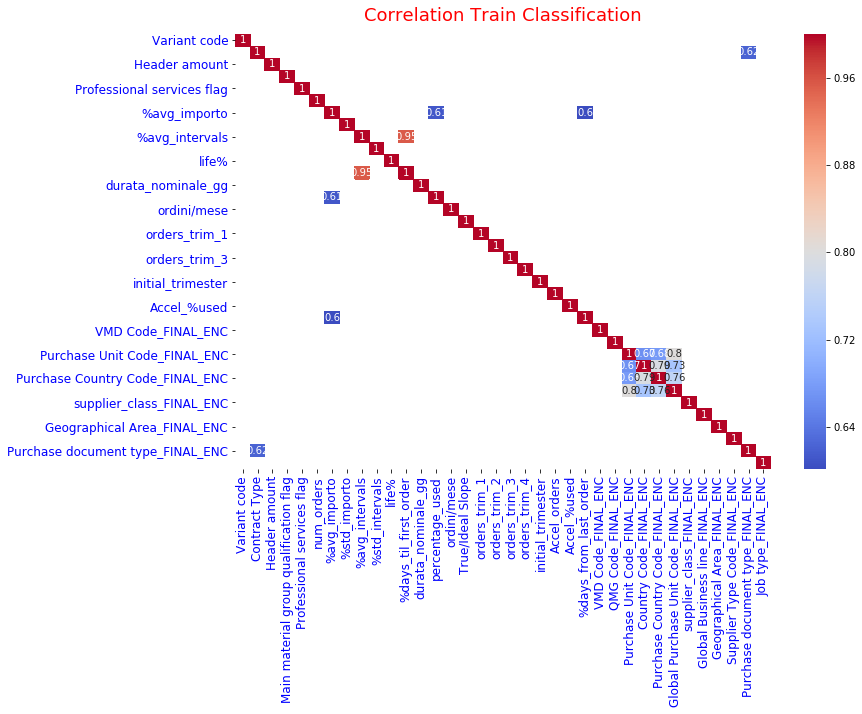

In [133]:
showprint= True

if showprint:
    df= container_class['X_train']
    soglia = 0.6

    title_ticks_ecc('Correlation Train Classification', '', '', figsize=(12, 8))
    sns.heatmap(df.corr()[abs(df.corr())> soglia ], cmap= 'coolwarm', annot= True,)

Encoding for Regression

In [184]:
### in class ho messo threshold=10
ratio_lens= X_train.shape[0]/ X_train_time.shape[0]  #qui devo mettere 3.5 volte di meno...mettero 3

thres_reg= int(np.ceil(thresh_class/ ratio_lens)) #Prendo intero superiore
thres_reg, thresh_class

(9, 30)

In [193]:
container_reg = encoding_cat_noise(X_train_reg, X_test_reg, target= 'Target%', verbose=False, threshold= 10,  n_folds= 100, minimum_std= 1, 
                                    prop_std_per_noise= 0.05 , showPrint= True)

Train and Test initial shapes (including target):  (76326, 38) (13270, 38)
Threshold is:  10
...Performing Encoding...

 COLUMN NAME:  VMD Code

 COLUMN NAME:  QMG Code

 COLUMN NAME:  Purchase Unit Code

 COLUMN NAME:  Country Code

 COLUMN NAME:  Purchase Country Code

 COLUMN NAME:  Global Purchase Unit Code

 COLUMN NAME:  Global Business line

 COLUMN NAME:  Geographical Area

 COLUMN NAME:  Supplier Type Code

 COLUMN NAME:  Purchase document type

 COLUMN NAME:  Job type
...Encoding Terminated...

 CORRETTO: Tutte colonne sono numeriche, a parte Purchase Doc!!
execution time (min) for rounding= 0.0

 Train and Test final shapes:  (76326, 36) (13270, 36)


In [195]:
container_reg['X_train'].iloc[:1, 24:]

,%days_from_last_order,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,Purchase Unit Code_FINAL_ENC,Country Code_FINAL_ENC,Purchase Country Code_FINAL_ENC,Global Purchase Unit Code_FINAL_ENC,Global Business line_FINAL_ENC,Geographical Area_FINAL_ENC,Supplier Type Code_FINAL_ENC,Purchase document type_FINAL_ENC,Job type_FINAL_ENC
Purchase document,,,,,,,,,,,,
DI\8400060305,-1.0,74.9699,72.5579,70.5576,71.3862,70.9262,67.7962,64.5084,67.4962,73.2402,77.5046,66.993


In [196]:
for col in container_reg['X_train'].iloc[:, 25:]:
    print('Redoundancy {}-->  {}'.format(col, container_reg['X_train'][col].value_counts().sort_values(ascending= False).iloc[0]))

print('\nIn test set no Noise, perciò redoundancy più alta\n')
for col in container_reg['X_test'].iloc[:, 25:]:
    print('Redoundancy {}-->  {}'.format(col, container_reg['X_test'][col].value_counts().sort_values(ascending= False).iloc[0]))

Redoundancy VMD Code_FINAL_ENC-->  7
Redoundancy QMG Code_FINAL_ENC-->  4
Redoundancy Purchase Unit Code_FINAL_ENC-->  5
Redoundancy Country Code_FINAL_ENC-->  6
Redoundancy Purchase Country Code_FINAL_ENC-->  6
Redoundancy Global Purchase Unit Code_FINAL_ENC-->  6
Redoundancy Global Business line_FINAL_ENC-->  6
Redoundancy Geographical Area_FINAL_ENC-->  9
Redoundancy Supplier Type Code_FINAL_ENC-->  10
Redoundancy Purchase document type_FINAL_ENC-->  7
Redoundancy Job type_FINAL_ENC-->  8

In test set no Noise, perciò redoundancy più alta

Redoundancy VMD Code_FINAL_ENC-->  4111
Redoundancy QMG Code_FINAL_ENC-->  593
Redoundancy Purchase Unit Code_FINAL_ENC-->  1284
Redoundancy Country Code_FINAL_ENC-->  4840
Redoundancy Purchase Country Code_FINAL_ENC-->  5709
Redoundancy Global Purchase Unit Code_FINAL_ENC-->  3428
Redoundancy Global Business line_FINAL_ENC-->  3881
Redoundancy Geographical Area_FINAL_ENC-->  8430
Redoundancy Supplier Type Code_FINAL_ENC-->  12138
Redoundancy Purc

In [197]:
## Example to show features Created for one contract
container_reg['X_train'].loc['DI\\8400060305']

,Variant code,Contract Type,Header amount,Main material group qualification flag,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,label,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,Purchase Unit Code_FINAL_ENC,Country Code_FINAL_ENC,Purchase Country Code_FINAL_ENC,Global Purchase Unit Code_FINAL_ENC,Global Business line_FINAL_ENC,Geographical Area_FINAL_ENC,Supplier Type Code_FINAL_ENC,Purchase document type_FINAL_ENC,Job type_FINAL_ENC
Purchase document,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DI\8400060305,1,0,9800000.0,0,0,0,0.000,0.000,0.077,0.000,0.0,0.077,1303,0.00,0.00,1,0.00,0.000,0.000,0.000,0.000,4,0.000,0.000,-1.00,74.9699,72.5579,70.5576,71.3862,70.9262,67.7962,64.5084,67.4962,73.2402,77.5046,66.9930
DI\8400060305,1,0,9800000.0,0,0,1543,0.005,0.009,0.008,0.077,10.0,2.993,1303,7.68,356.08,1,76.98,0.000,0.000,0.000,0.000,4,1.000,1.000,0.00,70.6327,71.0583,74.5009,69.0643,68.1271,70.1261,67.9869,67.0798,72.5999,78.0526,65.6136
DI\8400060305,1,0,9800000.0,0,0,3266,0.005,0.008,0.008,0.054,20.0,2.993,1303,14.80,376.85,1,74.17,0.419,0.376,0.205,0.000,4,1.117,0.927,0.00,72.4305,69.4880,72.9511,69.2399,69.0402,67.5705,64.9625,68.0448,73.2940,79.0543,68.9146
DI\8400060305,1,0,9800000.0,0,0,5096,0.004,0.007,0.008,0.046,30.0,2.993,1303,22.23,392.00,1,74.27,0.268,0.241,0.251,0.239,4,1.062,1.044,0.00,72.3003,73.8850,71.1006,68.0188,69.5788,66.2719,68.3006,64.5158,71.2467,76.8250,66.9191
DI\8400060305,1,0,9800000.0,0,0,6736,0.005,0.007,0.008,0.046,40.0,2.993,1303,30.40,387.87,1,76.03,0.417,0.274,0.209,0.100,4,0.896,1.100,0.00,71.4038,70.8589,72.9322,67.9956,67.4043,68.8246,65.8054,66.5975,73.5685,81.2273,67.3302
DI\8400060305,1,0,9800000.0,0,0,8672,0.004,0.007,0.008,0.038,50.0,2.993,1303,37.90,399.63,1,75.86,0.231,0.226,0.432,0.110,4,1.180,0.918,0.00,73.9421,72.7023,72.2722,69.7353,66.8513,69.1763,62.9352,68.6752,72.7487,78.9790,68.2154
DI\8400060305,1,0,9800000.0,0,0,10938,0.004,0.007,0.008,0.038,60.0,2.993,1303,47.78,420.15,1,79.71,0.280,0.229,0.238,0.254,4,1.170,1.317,0.00,70.7743,73.1463,73.9432,67.6361,70.6319,68.5382,66.5803,64.7539,71.6127,78.9102,64.6015
DI\8400060305,1,0,9800000.0,0,0,13730,0.004,0.007,0.008,0.031,70.0,2.993,1303,61.06,451.64,1,87.24,0.284,0.320,0.231,0.165,4,1.232,1.344,0.11,71.3899,72.5682,75.7121,64.4606,69.0528,68.6955,67.8316,66.5393,72.6073,79.6013,66.9587
DI\8400060305,1,0,9800000.0,0,0,15848,0.004,0.007,0.008,0.031,80.0,2.993,1303,69.99,456.28,1,87.52,0.267,0.226,0.339,0.168,4,0.759,0.672,0.00,74.3593,71.8143,74.3790,68.7022,69.7519,66.2603,66.4437,66.8174,73.6826,78.1978,67.8553


### Target Encoding for Dataset with 2 outputs (2 targets) to do with NN

In [267]:
################################# PER DUE OUTPUTS ########################
container_time= encoding_cat_noise(X_train_time, X_test_time, target= 'Target%', verbose=False, threshold= 10,  n_folds= 100, minimum_std= 1, 
                                    prop_std_per_noise= 0.05 , showPrint= True)

Train and Test initial shapes (including target):  (259053, 38) (45511, 38)
Threshold is:  10
...Performing Encoding...

 COLUMN NAME:  VMD Code

 COLUMN NAME:  QMG Code

 COLUMN NAME:  Purchase Unit Code

 COLUMN NAME:  Country Code

 COLUMN NAME:  Purchase Country Code

 COLUMN NAME:  Global Purchase Unit Code

 COLUMN NAME:  Global Business line

 COLUMN NAME:  Geographical Area

 COLUMN NAME:  Supplier Type Code

 COLUMN NAME:  Purchase document type

 COLUMN NAME:  Job type
...Encoding Terminated...

 CORRETTO: Tutte colonne sono numeriche, a parte Purchase Doc!!
execution time (min) for rounding= 0.1

 Train and Test final shapes:  (259053, 36) (45511, 36)


In [199]:
container_time['X_train'].drop(['label'], axis=1, inplace= True, errors= 'ignore')
container_time['X_test'].drop(['label'], axis=1, inplace= True, errors= 'ignore')

container_reg['X_train'].drop(['label'], axis=1, inplace= True, errors= 'ignore')
container_reg['X_test'].drop(['label'], axis=1, inplace= True, errors= 'ignore')

container_class['X_train'].drop(['supplier_class_FINAL_ENC'], axis=1, inplace= True, errors= 'ignore')
container_class['X_test'].drop(['supplier_class_FINAL_ENC'], axis=1, inplace= True, errors= 'ignore')

## Normalizing Data using Robust Scaler

In [269]:
containers= [container_class, container_reg, container_time]
len(X_sets_class)

2

In [270]:
encoded_cols= [col for col in df.columns if col.endswith('ENC') ] 
for cont in containers:
    for col in encoded_cols:
        if (container_reg['X_train'][col]== -1).sum() != 0 or (container_reg['X_train'][col]== -2).sum()!=0:
            print('SBAGLIATO, HO CAMBIATO VALORI CHE NON DOVEVO CAMBIARE')
        if (container_reg['X_test'][col]== -1).sum() != 0 or (container_reg['X_test'][col]== -2).sum()!=0:
            print('SBAGLIATO, HO CAMBIATO VALORI CHE NON DOVEVO CAMBIARE')

print('##########TUTTO OK############')

##########TUTTO OK############


In [271]:
feats_binarie= ['Variant code',
 'Contract Type',
 'Main material group qualification flag',
 'Professional services flag']

feats_binarie

['Variant code',
 'Contract Type',
 'Main material group qualification flag',
 'Professional services flag']

In [272]:
for cont in containers:
    scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
    cont['X_train']= pd.DataFrame(scaler.fit_transform(cont['X_train']), columns= cont['X_train'].columns, index= cont['X_train'].index )
    cont['X_test']= pd.DataFrame(scaler.transform(cont['X_test']), columns= cont['X_train'].columns, index= cont['X_test'].index)

In [275]:
ytrain_reg, ytest_reg= container_reg['ytrain'], container_reg['ytest']

In [209]:
### Defining MAPE (Mean Absolute Percentage Error)


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer

def MAPE(y_true, y_pred):   #
    """mean_absolute_percentage_error. Nel mio caso non ha senso, sono gia tutte percentuali. Se divido per y_true, 
    #ho quasi divisione per 0 a volte...perciò meglio MAE, che essendo su valori % funge praticamente da MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = make_scorer(MAPE, greater_is_better=False)
MAE= mean_absolute_error
mae= make_scorer(MAE, greater_is_better= False)

### Taking off highly correlated feats to avoid multicollinearity

In [217]:
feats_create= [col for col in feats_create if col not in ['life%_enc', 'label', 'gg rimanenti Statico','Purchase document']+ feats_binarie]+[ 
                                    'Header amount' ]

feats_create

['num_orders',
 '%avg_importo',
 '%std_importo',
 '%avg_intervals',
 '%std_intervals',
 'life%',
 '%days_from_last_order',
 '%days_til_first_order',
 'durata_nominale_gg',
 'percentage_used',
 'ordini/mese',
 'True/Ideal Slope',
 'orders_trim_1',
 'orders_trim_2',
 'orders_trim_3',
 'orders_trim_4',
 'initial_trimester',
 'Accel_orders',
 'Accel_%used',
 'Header amount']

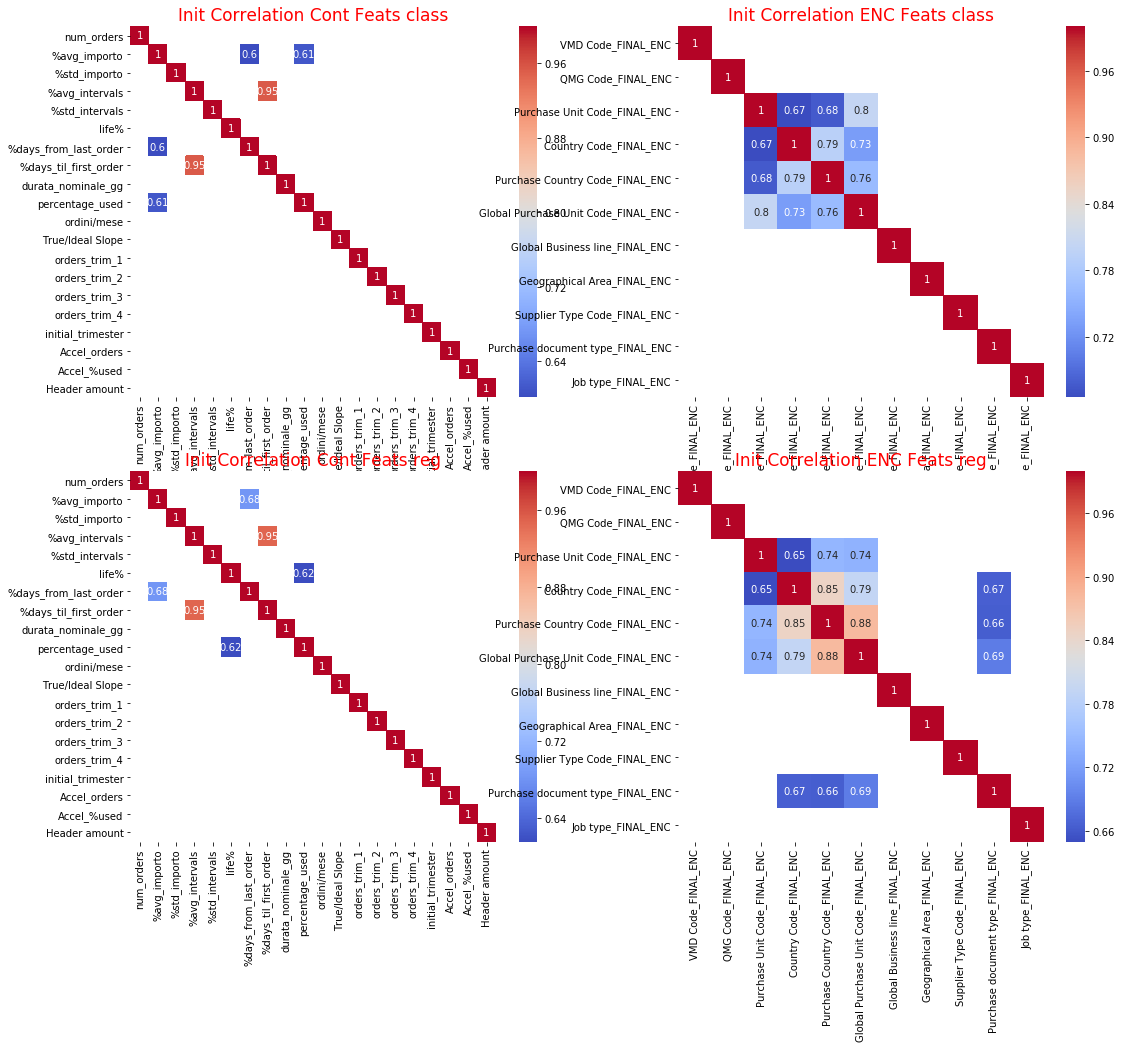

In [218]:
df_cont= container_class['X_train'][feats_create]
df_enc= container_class['X_train'][encoded_cols]

df_reg_cont= container_reg['X_train'][feats_create]
df_reg_enc= container_reg['X_train'][encoded_cols]

    
plt.figure(figsize=(18,15))

plt.subplot(2,2,1,)
plt.title('Init Correlation Cont Feats class', color='red', fontsize=17)
sns.heatmap(df_cont.corr()[df_cont.corr() >0.6], cmap='coolwarm', annot=True)

plt.subplot(2,2,2, )
plt.title('Init Correlation ENC Feats class', color='red', fontsize=17)
sns.heatmap(df_enc.corr()[df_enc.corr() >0.6], cmap='coolwarm', annot=True)

plt.subplot(2,2,3)
plt.title('Init Correlation Cont Feats reg', color='red', fontsize=17)
sns.heatmap(df_reg_cont.corr()[df_reg_cont.corr() >0.6], cmap='coolwarm', annot=True)

plt.subplot(2,2,4)
plt.title('Init Correlation ENC Feats reg', color='red', fontsize=17)
sns.heatmap(df_reg_enc.corr()[df_reg_enc.corr() >0.6], cmap='coolwarm', annot=True)

In [221]:
corr_feats_to_cut= ['Purchase Country Code_FINAL_ENC', 'Country Code_FINAL_ENC', 'Global Purchase Unit Code_FINAL_ENC']
temp_uncorr= container_class['X_train'][[col for col in container_class['X_train'].columns if col not in corr_feats_to_cut]]

In [222]:
diz= {}
for col in temp_uncorr.columns:
    colonna= temp_uncorr.corr()[col]  
    diz[col]= colonna[abs(colonna) >0.5].squeeze()

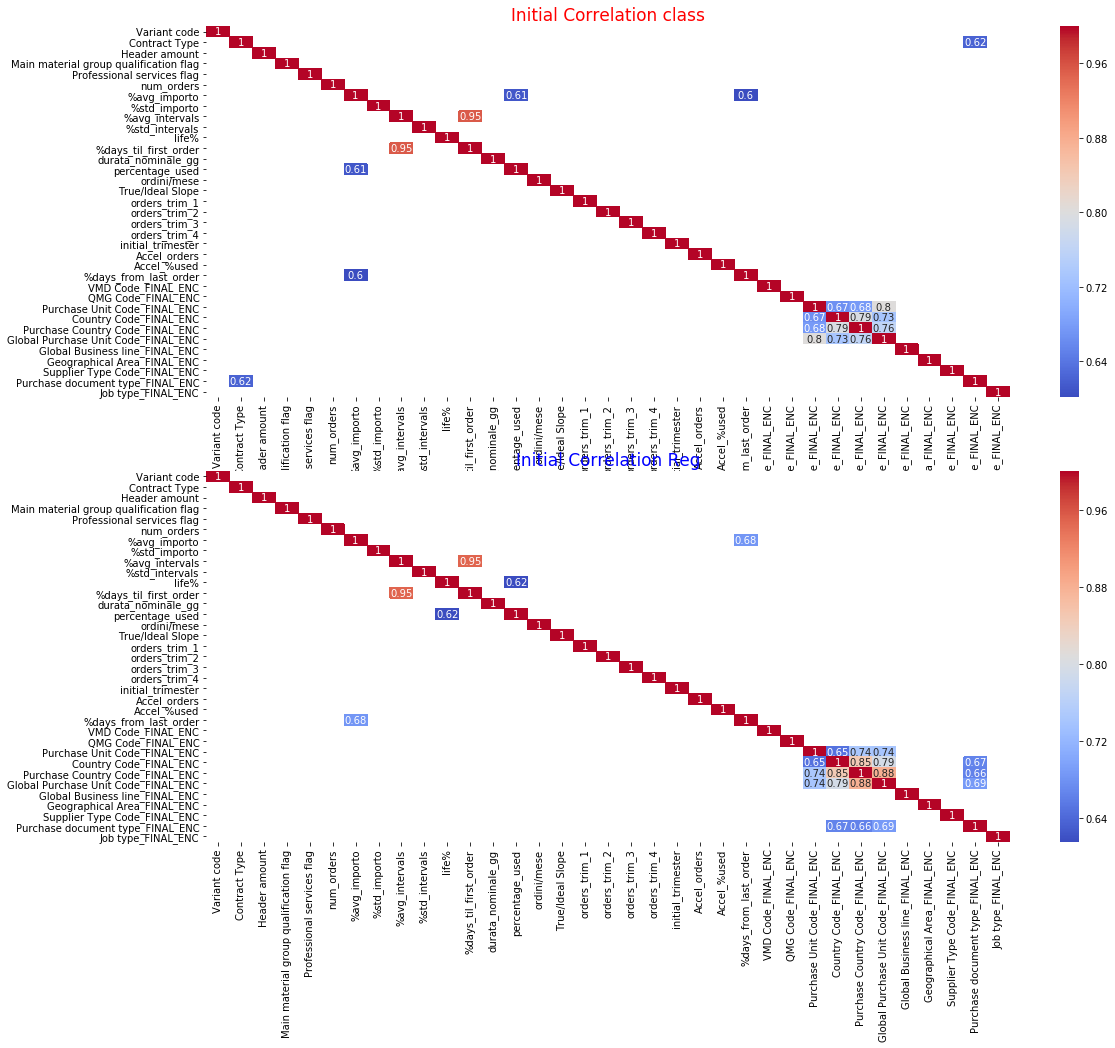

In [223]:
df_class = container_class['X_train']
df_reg = container_reg['X_train']


plt.figure(figsize=(18,15))

plt.subplot(2,1,1,)
plt.title('Initial Correlation class', color='red', fontsize=17)
sns.heatmap(df_class.corr()[df_class.corr() >0.6], cmap='coolwarm', annot=True)

plt.subplot(2,1,2, )
plt.title('Initial Correlation Reg', color='blue', fontsize=17)
sns.heatmap(df_reg.corr()[df_reg.corr() >0.6], cmap='coolwarm', annot=True)

In [226]:
for cont in containers:
    for el in ['X_train', 'X_test']:
        cont[el]= cont[el][temp_uncorr.columns]
        
container_reg['X_train'].shape, container_class['X_train'].shape #((67854, 28), (232298, 25))

((76326, 32), (259053, 32))

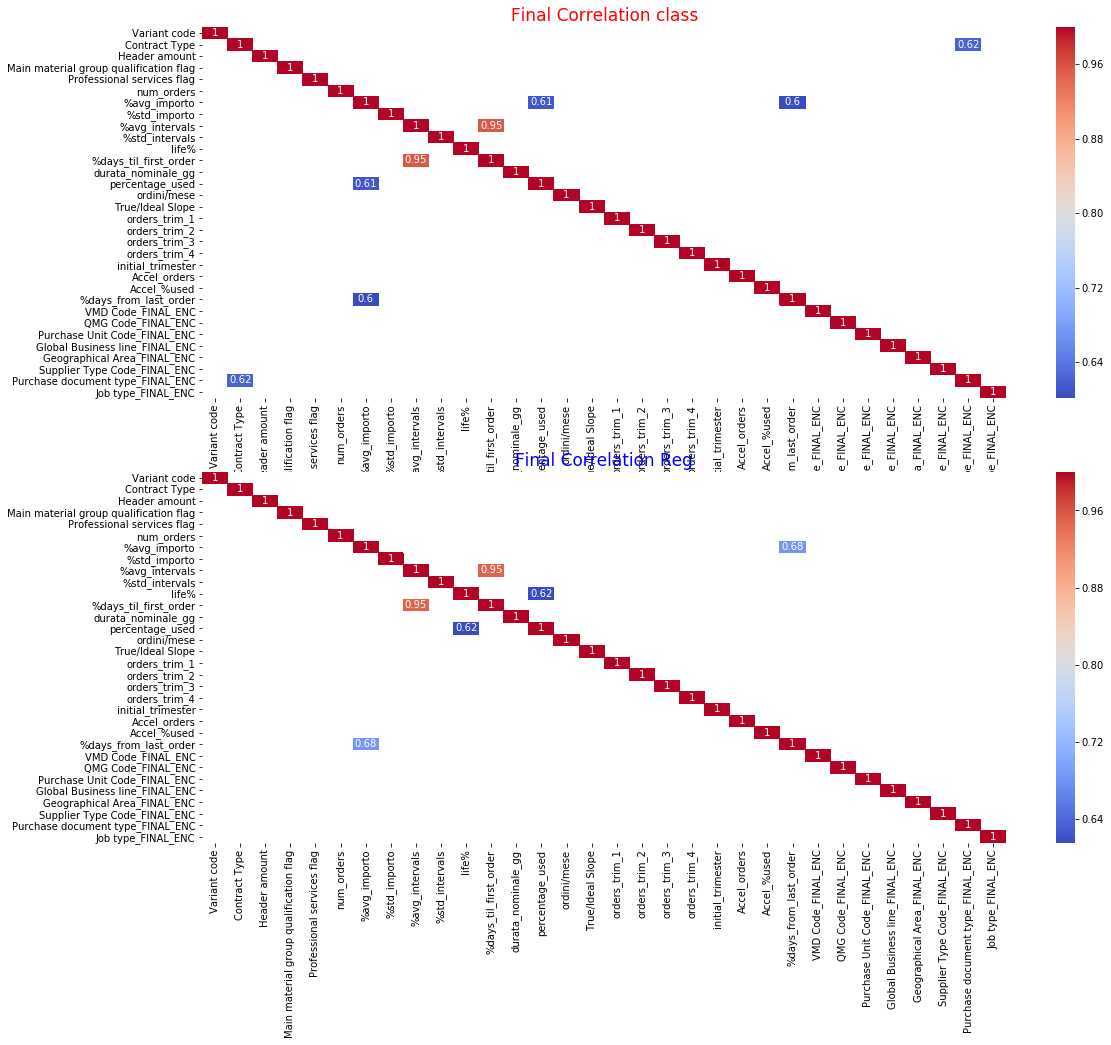

In [227]:
df_class = container_class['X_train']
df_reg = container_reg['X_train']


plt.figure(figsize=(18,15))

plt.subplot(2,1,1,)
plt.title('Final Correlation class', color='red', fontsize=17)
sns.heatmap(df_class.corr()[df_class.corr() >0.6], cmap='coolwarm', annot=True)

plt.subplot(2,1,2, )
plt.title('Final Correlation Reg', color='blue', fontsize=17)
sns.heatmap(df_reg.corr()[df_reg.corr() >0.6], cmap='coolwarm', annot=True)

In [277]:
def container_modello(task):
    """Return un diz con chiavi X_train, X_test, y_train, y_test, best_estimator
    caso: 'classo', 'rollingreg', 'rollingreg' """
    
    if task== 'class':
        X_train= container_class['X_train']
        X_test= container_class['X_test']
        y_train= container_class['ytrain']
        y_test= container_class['ytest']
        #best_est= best_class_rf
        #feat_imp= feats_imp_class
        
    elif task== 'reg':
        X_train= container_reg['X_train']
        X_test= container_reg['X_test']
        y_train= container_reg['ytrain']
        y_test= container_reg['ytest']
        #best_est= best_reg_rf
        #feat_imp= feats_imp_rfreg
        
    return {'X_train': X_train, 'X_test': X_test, 'ytrain': y_train, 'ytest': y_test} #, 'best_estimator': best_est,
           #'feat_imp': feats_imp_rfreg}

### FULL DATASET FOR TWO OUTPUT NEURAL NETWORK

In [278]:
container_class['X_train'].shape,  container_class['X_train'].shape

((259053, 32), (259053, 32))

In [280]:
encoded_cols

['VMD Code_FINAL_ENC',
 'QMG Code_FINAL_ENC',
 'Purchase Unit Code_FINAL_ENC',
 'Global Business line_FINAL_ENC',
 'Geographical Area_FINAL_ENC',
 'Supplier Type Code_FINAL_ENC',
 'Purchase document type_FINAL_ENC',
 'Job type_FINAL_ENC']

In [282]:
### IN DOUBLE OUTPUT I CONCATENATE ENCODED VARIABLES

encoded_cols= [col for col in encoded_cols if col not in corr_feats_to_cut]
temp= container_time['X_train'][encoded_cols]
temp.columns= [col[:-9]+ ('ENC_REG') for col in temp.columns]

temp_test= container_time['X_test'][encoded_cols]
temp_test.columns= temp.columns

X_train_double= pd.concat([container_class['X_train'], temp ], axis=1, )
X_test_double= pd.concat([container_class['X_test'], temp_test ], axis=1, )

X_train_double.head()

,Variant code,Contract Type,Header amount,Main material group qualification flag,Professional services flag,num_orders,%avg_importo,%std_importo,%avg_intervals,%std_intervals,life%,%days_til_first_order,durata_nominale_gg,percentage_used,ordini/mese,True/Ideal Slope,orders_trim_1,orders_trim_2,orders_trim_3,orders_trim_4,initial_trimester,Accel_orders,Accel_%used,%days_from_last_order,VMD Code_FINAL_ENC,QMG Code_FINAL_ENC,Purchase Unit Code_FINAL_ENC,Global Business line_FINAL_ENC,Geographical Area_FINAL_ENC,Supplier Type Code_FINAL_ENC,Purchase document type_FINAL_ENC,Job type_FINAL_ENC,VMD Code_ENC_REG,QMG Code_ENC_REG,Purchase Unit Code_ENC_REG,Global Business line_ENC_REG,Geographical Area_ENC_REG,Supplier Type Code_ENC_REG,Purchase document type_ENC_REG,Job type_ENC_REG
Purchase document,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DI\8400060305,0.0,0.0,34.062064,-1.0,0.0,-0.2,-0.096874,0.000000,-0.424411,0.000000,-0.8,-0.394322,1.931264,-0.139665,-0.151899,-0.188125,0.000,0.000000,0.000000,0.000,1.0,0.000,0.000000,-0.097488,-0.320479,0.730317,0.753115,0.858125,3.444136,-0.579482,-0.339160,-0.229123,0.158622,0.059567,-0.572827,-0.338417,-4.520735,-0.100124,0.175001,-0.547563
DI\8400060305,0.0,0.0,34.062064,-1.0,0.0,308.4,-0.096140,0.006429,-0.427642,0.024895,-0.6,-0.284813,1.931264,0.039106,450.582278,0.727868,0.000,0.000000,0.000000,0.000,1.0,1.000,1.184834,-0.042034,-0.278266,0.727517,0.756616,0.070357,3.082885,-0.335654,-0.297114,0.007502,0.135494,0.050727,-0.587472,0.018120,-5.442303,0.955134,-0.083367,-0.452517
DI\8400060305,0.0,0.0,34.062064,-1.0,0.0,653.0,-0.096140,0.005714,-0.427642,0.017459,-0.4,-0.284813,1.931264,0.204842,476.873418,0.694431,0.419,53.714286,4.361702,0.000,1.0,1.117,1.098341,-0.042034,0.303535,0.718242,0.737346,-0.255094,3.042211,-0.365904,-0.088516,-1.472670,0.085017,-0.040085,-0.835412,-0.043378,-5.971433,-0.337408,0.026286,0.237333
DI\8400060305,0.0,0.0,34.062064,-1.0,0.0,1019.0,-0.096287,0.005000,-0.427642,0.014872,-0.2,-0.284813,1.931264,0.377793,496.050633,0.695621,0.268,34.428571,5.340426,0.239,1.0,1.062,1.236967,-0.042034,0.237103,0.710604,0.859104,-0.134151,3.586791,0.818358,-0.373263,-1.154477,0.150133,-0.009496,-0.379165,0.185704,-4.766509,-0.462124,0.105062,-0.925690
DI\8400060305,0.0,0.0,34.062064,-1.0,0.0,1347.0,-0.096140,0.005000,-0.427642,0.014872,0.0,-0.284813,1.931264,0.567970,490.822785,0.716564,0.417,39.142857,4.446809,0.100,1.0,0.896,1.303318,-0.042034,0.160707,0.800313,0.821671,0.553508,3.320230,0.298479,0.105198,-0.192770,0.143153,0.144843,-0.807852,-0.305385,-4.686894,-0.484227,0.110361,-0.727772


In [283]:
X_train_double.shape, X_test_double.shape #((226770, 33), (39997, 33))

((259053, 40), (45511, 40))

In [284]:
targets= {}
targets['class']= [container_class['ytrain'], container_class['ytest']]
targets['reg']= [container_time['ytrain'], container_time['ytest']]

targets.keys()

dict_keys(['class', 'reg'])

### Checking Correlation of Encoded variables with Target to have a first idea of overfitting

In [235]:
def corr_with_labels(task, figsize= (10,4), return_df= False, n_to_show= 5):
    """task= ['statico', rolling25']"""
    container= container_modello(task)

    X_train= container['X_train']
    ytrain= container['ytrain']
    X_test= container['X_test']
    ytest= container['ytest']
        
    corr_with_label_train= {}
    for i in range (len(X_train.columns)):
        corr= np.min(np.corrcoef(X_train.iloc[:, i], ytrain))
        corr_with_label_train[X_train.columns[i]] = corr
    corr_with_label_train = pd.DataFrame(pd.Series(corr_with_label_train)).sort_values(by = [0], ascending= False)
    corr_with_label_train.columns= ['Corr Train']
    
    
    corr_with_label_test= {}
    for i in range (len(X_test.columns)):
        corr= np.min(np.corrcoef(X_test.iloc[:, i], ytest))
        corr_with_label_test[X_test.columns[i]] = corr
    
    corr_with_label_test = pd.DataFrame(pd.Series(corr_with_label_test)).sort_values(by = [0], ascending= False)
    corr_with_label_test.columns= ['Corr Test']
    
    cor_train_test= corr_with_label_train.join(corr_with_label_test)
        
    cor_train_test.plot(kind='bar')
    title_ticks_ecc('Correlation features & label {}'.format(task), '', '', new_fig=False)
    plt.ylim(0,1)
    
    if return_df== True:
        return cor_train_test.head(n_to_show)

In [239]:
########### E' cardinalità su tutto il Training Set #############
cardinalita= cardinalita.drop(['Purchase document', 'Country Code','Global Purchase Unit Code', 'Purchase Unit Code', 
                               'Validity end date', 'Validity start date', 'Main Requesting unit'], errors= 'ignore')
cardinalita.head(8)

,cardinalità_classe
VMD Code,12191
QMG Code,878
Purchase Country Code,13
life%,10
Global Business line,8
Geographical Area,5
Supplier Type Code,5
Purchase document type,4


,Corr Train,Corr Test
percentage_used,0.426980,0.418267
Purchase Unit Code_FINAL_ENC,0.330821,0.321566
VMD Code_FINAL_ENC,0.300828,0.295196


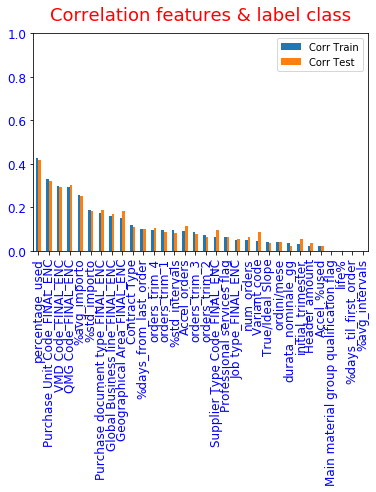

In [240]:
corr_with_labels(task= 'class', return_df= True, n_to_show= 3)

,Corr Train,Corr Test
life%,0.486971,0.492090
Purchase Unit Code_FINAL_ENC,0.346477,0.334505
VMD Code_FINAL_ENC,0.318219,0.317788
QMG Code_FINAL_ENC,0.289467,0.291837
Purchase document type_FINAL_ENC,0.270162,0.262605
percentage_used,0.255989,0.268780
%days_til_first_order,0.241682,0.241787


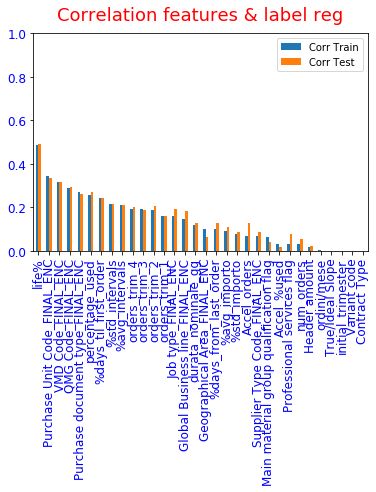

In [242]:
corr_with_labels(task= 'reg', return_df= True, n_to_show= 7)  

<b> Each encoded variable in Train and Test has similar correlation, thus the Custom Target Encoding has done a good job

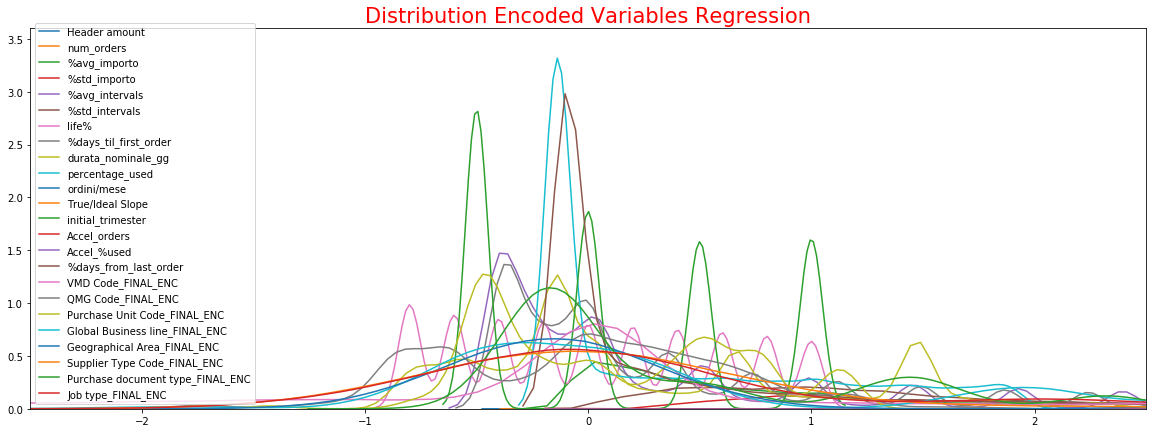

In [244]:
### Idea of distribution of variables

df= container_class['X_train'].drop(feats_binarie+ trimesters_cols, axis=1)

plt.figure(figsize= (20,7))
plt.title('Distribution Encoded Variables Regression', fontsize= 21, color= 'red')
plt.xlim(-2.5, 2.5)
plt.ylim(-0.5, 3.6)
for col in df.drop(feats_binarie, axis=1, errors= 'ignore').columns[:]:
    #if col!= 'Geographical Area_enc':
    sns.kdeplot(df[col])

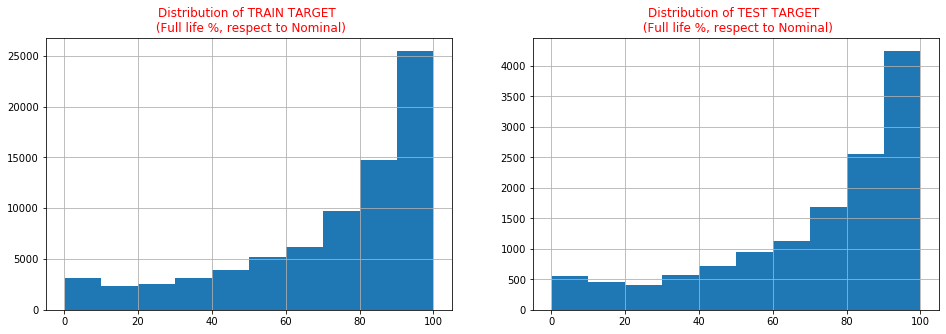

In [246]:
plt.figure(figsize= (16,5))

plt.subplot(1,2,1)
plt.title('Distribution of TRAIN TARGET \n (Full life %, respect to Nominal)', color='red')
container_reg['ytrain'].hist()

plt.subplot(1,2,2)
plt.title('Distribution of TEST TARGET \n (Full life %, respect to Nominal)', color='red')
container_reg['ytest'].hist()

Text(0, 0.5, 'TARGET (= LIFE TIME%)')

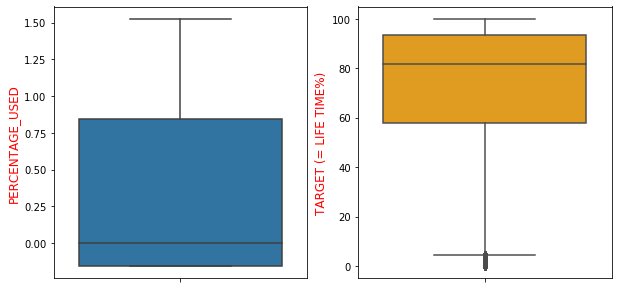

In [249]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
sns.boxplot(container_reg['X_train']['percentage_used'],  orient='v')
plt.ylabel('PERCENTAGE_USED', color='red', fontsize= 12)

plt.subplot(1,2,2)
sns.boxplot(ytrain_reg,  orient='v', color='orange')
plt.ylabel('TARGET (= LIFE TIME%)', color='red', fontsize= 12)

(-2, 4)

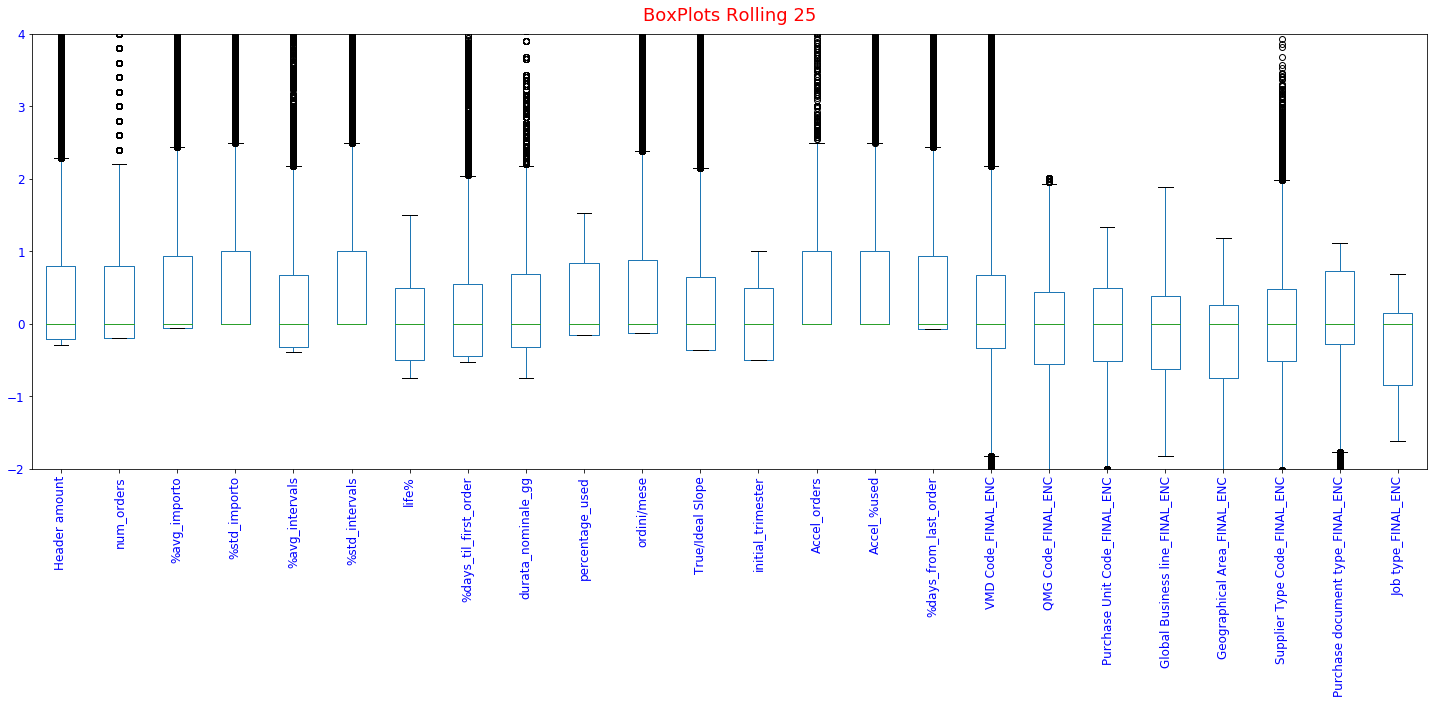

In [253]:
container_reg['X_train'].drop(feats_binarie+ trimesters_cols, axis=1).plot(kind= 'box', figsize= (25,8))
title_ticks_ecc('BoxPlots Rolling 25', '', '', figsize=(30, 10), new_fig= False)

plt.xticks(rotation= 90)
plt.ylim(-2, 4)

## Export Files

In [256]:
import pickle

with open('./datasets/final_class_10sn.pickle', 'wb') as cont_class:
    pickle.dump(container_class, cont_class, protocol=pickle.HIGHEST_PROTOCOL)

with open('./datasets/final_reg_10sn.pickle', 'wb') as cont_reg:
    pickle.dump(container_reg, cont_reg, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open('./datasets/container_25.pickle', 'rb') as container:
    #container_25 = pickle.load(container)
    
#with open('./datasets/container_static.pickle', 'rb') as container_stat:
    #container_static = pickle.load(container_stat)

In [11]:
########################################### END PART 2 ##############################################################